# SI: Aggregate Size-Dependence of Amyloid Adsorption onto Charged Interfaces

_Giulio Tesei, Erik Hellstrand, Kalyani Sanagavarapu, Sara Linse, Emma Sparr, Robert Vacha, and Mikael Lund_

## System Requirements
The required python modules to run this Jupyter Notebook are specified in the environment file environment.yml

In [348]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os.path, os, sys, json, shutil
from pathlib import Path
import mdtraj as md
from scipy import optimize
from math import asinh, sqrt, pi
from pylab import cm, imshow, contour, clabel, colorbar
from scipy.optimize import brenth
from scipy.special import k0
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')
def find_nearest(y,y0):
    idx = (np.abs(y-y0)).argmin()
    return idx
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/Users/giulio/JPCL-submit/SI


## Metropolis Monte Carlo (MC) Simulations

### Download and build Faunus

To simulate the interaction of rigid fibrils with a charged, planar surface we use a custom MC program build within the [Faunus framework](http://github.com/mlund/faunus.git). The sections below will fetch the Faunus project and compile the appropriate version of the program.

In [ ]:
%%bash -s "$workdir"
module purge
module add GCC/6.2.0-2.27
module add CMake
cd $1

if [ ! -d "faunus" ]; then
  git clone https://github.com/mlund/faunus.git
  cd faunus
else
  cd faunus
fi

cmake . -DENABLE_APPROXMATH=on -DCMAKE_BUILD_TYPE=Release -DMYPLAYGROUND=`pwd`/../mc/ #&>/dev/null
make r2s -j4
make theta -j4
make cc -j4
cd $1

### Create slurm submit script for cluster runs
This part is only for performing the calculations on a cluster, here assumed to use `slurm` for submitting jobs. Below you specify number of processers (`-N`), cores (`-n`) and wall time for each job to be submitted.

In [3]:
%%writefile mc/submit.sh
#!/bin/bash
#SBATCH -p snic
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -A snic2017-1-48
#
# job time, change for what your job requires 
#SBATCH -t 20:00:00
# 
# job name
#SBATCH -J fibril
#
# filenames stdout and stderr - customise, include %j
#SBATCH -o fibrils.out
#SBATCH -e fibrils.err

module purge
module add GCC/6.2.0-2.27
module add CMake

../../r2s > out

Writing mc/submit.sh


### Extract aggregate from long fibril structure
Peptides are ordered according to their position along the fibril axis. The N-terminal D is a neutral NTR bead, whereas the C-terminal A is a negatively charged CTR bead.

In [4]:
# t is the pdb file
# numpep is the number of peptides in the final aggregate
# peplen is the number of residues per peptide, e.g. 42 for Abeta1-42
# startres is the index of the starting residue, e.g. 17 for Abeta17-42
def masscenter(residue, xyz):
    ''' mass center of residue '''
    cm = [0,0,0] # residue mass center
    mw = 0       # residue mass
    for a in residue.atoms:
        cm = cm + a.element.mass * xyz[a.index]
        mw = mw + a.element.mass
    return cm/mw

def coarsegrain(t):
    ''' generates a CG version of trajectory (residue mass center level) '''
    cnt=0
    cgtop = md.Topology()       # new CG topology
    cgchain = cgtop.add_chain() # new CG chain
    cgxyz   = []                # new CG positions

    for i in t.top.residues: # add CG residues and atoms
        cgres = cgtop.add_residue(i.name, cgchain)
        atom = cgtop.add_atom(i.name, element=md.element.argon, residue=cgres)

    for aapos in t.xyz:      # coarse grain each frame
        cnt=cnt+1
        pos = []
        for res in t.top.residues:
            pos.append(masscenter(res, aapos))
        cgxyz.append( pos )

    return md.Trajectory(cgxyz, topology=cgtop, unitcell_lengths=t.unitcell_lengths, unitcell_angles=t.unitcell_angles)

def extract_agg(t, numpep, peplen, startres):
    t = coarsegrain(t)
    met = np.empty(0)
    for i in t.topology.atoms:
        if (i.name=='MET'):
            met = np.append(met, [i.index,t.xyz[0][i.index][2]])
    met = met.reshape((int(met.size/2),2))
    order = met[:,1].argsort()
    met = np.take(met, order, 0)
    if peplen == 40:
        first_z = (met[:,0]-peplen+6).astype(int)
    else:
        first_z = (met[:,0]-peplen+8).astype(int)
        
    cnt=0
    cgtop = md.Topology()       # new CG topology
    cgchain = cgtop.add_chain() # new CG chain
    cgxyz   = []                # new CG positions

    for i in first_z[int((first_z.size-numpep)/2):int((first_z.size+numpep)/2)]:
        cgres = cgtop.add_residue("NTR", cgchain)
        atom = cgtop.add_atom("NTR", element=md.element.argon, residue=cgres)
        # the N-term ASP is merged with NH3+ and is neutral
        cgxyz.append( t.xyz[0][i+startres-1][:] )
        for j in range(i+startres,i+peplen-1):
            cgres = cgtop.add_residue(t.top.atom(j).name, cgchain)
            atom = cgtop.add_atom(t.top.atom(j).name, element=md.element.argon, residue=cgres)
            cgxyz.append( t.xyz[0][j][:] )
        cgres = cgtop.add_residue("CTR", cgchain)
        atom = cgtop.add_atom("CTR", element=md.element.argon, residue=cgres)
        # the C-term ALA is merged with COO- and is negatively charged
        cgxyz.append( t.xyz[0][i+peplen-1][:] )

    return md.Trajectory(cgxyz, topology=cgtop, unitcell_lengths=t.unitcell_lengths, unitcell_angles=t.unitcell_angles)

### Create Input and run Monte Carlo simulation

This will generate all input for MC simulations as well as loop over the full parameter space.
In the inner loop you may specify if the jobs should be run locally (not recommended) or be submitted to a cluster, assuming you are running this Notebook from a cluster environment.

In [349]:
%cd $workdir

def mkinput():
    js = {
      "atomlist" : {
        "NTR"  :  { "q":charge_ntr,  "r":3.6, "mw":110 },
        "ASP"  :  { "q":-1, "r":3.6, "mw":110 },
        "CTR"  :  { "q":-1, "r":3.1, "mw":66 },
        "ALA"  :  { "q":0,  "r":3.1, "mw":66 },
        "GLU"  :  { "q":-1, "r":3.8, "mw":122 },
        "HIS"  :  { "q":0,  "r":3.9, "mw":130 },
        "TYR"  :  { "q":0,  "r":4.1, "mw":154 },
        "LYS"  :  { "q":1,  "r":3.7, "mw":116 },
        "CYS"  :  { "q":0,  "r":3.6, "mw":103 },
        "ARG"  :  { "q":1,  "r":4.0, "mw":144 },
        "ILE"  :  { "q":0,  "r":3.6, "mw":102 },
        "LEU"  :  { "q":0,  "r":3.6, "mw":102 },
        "MET"  :  { "q":0,  "r":3.8, "mw":122 },
        "PHE"  :  { "q":0,  "r":3.9, "mw":138 },
        "PRO"  :  { "q":0,  "r":3.4, "mw":90 },
        "TRP"  :  { "q":0,  "r":4.3, "mw":176 },
        "VAL"  :  { "q":0,  "r":3.4, "mw":90 },
        "SER"  :  { "q":0,  "r":3.3, "mw":82 },
        "THR"  :  { "q":0,  "r":3.5, "mw":94 },
        "ASN"  :  { "q":0,  "r":3.6, "mw":108 },
        "GLN"  :  { "q":0,  "r":3.8, "mw":120 },
        "GLY"  :  { "q":0,  "r":2.9, "mw":54 }
          },  
      "energy" : {
          "gouychapman" : { "qarea": qarea, "offset":3 },
          "nonbonded" : {
            "coulomb"  : { "epsr" : 78.54 },
            "ionicstrength": salt 
            },
          "penalty" : { 
                "xyz" : { "dir":"0 0 1", "first":"fibril", "bw1":1, "lo1":-len_z/4+min_dist, 
                         "hi1":len_z/2-min_dist, "f0":10, "scale":0.5, "update":1e4} 
            }  
          },
      "moves" : {
          "moltransrot"      : { "fibril" : { "dp":20, "dprot":6, "permol":True }  }
          },
      "moleculelist" : {
          "fibril" : { "Ninit":1, "structure":str(numpep)+".xyz" } 
          },
      "system" : {
          "temperature"  : 298,
          "geometry"   : { "length" : [2000, 2000, len_z] },
          "mcloop"       : { "macro":10, "micro": micro }
          },
      "analysis" : {
          "statefile" : { "file": "state" }
          }
    }
    with open('input.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))
        f.close()

%cd -q $workdir'/mc'

# parameter space
qarea        = 266 # 1 / surface charge density (angstrom^2/charge)
salt_range   = [.1,.15,.2,.25,.3,.35,.4,.45,1e10]
micro        = 20000000
len_z        = 600

fibrils = { '5KK3': {'peplen':42, 'startres': 1, 'file': '5KK3.pdb', 'min_dist':[10,16,25,27,29,32],
                     'numpep_range':[2,8,16,32,64,128], 'charge_ntr': 0 },
            '2BEG_17-42': {'peplen':26, 'startres': 1, 'file': '2BEG_17-42.pdb', 
                     'min_dist':[7,12,19,20,21,23], 'numpep_range':[2,8,16,32,64,128], 'charge_ntr': 1 },
            '2M4J': {'peplen':40, 'startres': 1, 'file': '2M4J.pdb', 'min_dist':[10,19,27,28,31,36],
                     'numpep_range':[3,12,24,48,96,192], 'charge_ntr': 0 }
          }

for name in ['2BEG_17-42','5KK3','2M4J']:
    if not Path(name+'-data.p').is_file(): # run only if this file is missing (see next section)
        fibril = fibrils[name]
        charge_ntr = fibril['charge_ntr']
        pdb = md.load_pdb(fibril['file'])
        if not os.path.isdir(name):
            %mkdir -p $name
        %cd $name
        for salt in salt_range:
            for numpep, min_dist in zip(fibril['numpep_range'],fibril['min_dist']):
                pfx='__rho'+str(qarea)+'-N'+str(numpep)+'-I'+str(salt)
                if not os.path.isdir(pfx):
                    print(min_dist)
                    %mkdir -p $pfx     
                    %cd $pfx
                    mkinput()
                    # generate CG aggregate
                    cg_agg = extract_agg( pdb, numpep, fibril['peplen'], fibril['startres'] )
                    cg_agg[0].save_xyz(str(numpep)+'.xyz')
                    if shutil.which('sbatch') is not None:
                        !sbatch ../../submit.sh  # run on slurm cluster
                    else:
                        !../../r2s > out         # run locally
                    %cd -q ..
        %cd -q ..

/Users/giulio/JPCL-submit/SI


### Read all distribution functions and calculate surface excess

For further analysis, we now load into a Pandas object all free energy profiles, $w(r)$, as a function of aggregate-surface separation, r.

$w(r)$ is integrated to obtain the Henry's law constants:

$$
K_{HA} = \int_{0}^{\infty} (e^{-w(r)/k_BT} - 1) dr.
$$

Note: All loaded MC data will be saved to disk as a _single_ picke file named `<PDB-ID>-data.p`. The next time this cell is run, this file will be loaded and no raw MC data is needed.

In [446]:
fibrils = { '5KK3': {'peplen':42, 'startres': 1, 'file': '5KK3.pdb', 'min_dist':[10,16,25,27,29,32],
                     'numpep_range':[2,8,16,32,64,128], 'charge_ntr': 0 },
            '2BEG_17-42': {'peplen':26, 'startres': 1, 'file': '2BEG_17-42.pdb', 
                     'min_dist':[7,12,19,20,21,23], 'numpep_range':[2,8,16,32,64,128], 'charge_ntr': 1 },
            '2M4J': {'peplen':40, 'startres': 1, 'file': '2M4J.pdb', 'min_dist':[10,19,27,28,31,36],
                     'numpep_range':[3,12,24,48,96,192], 'charge_ntr': 0 }
          }
salt_range   = [.1,.15,.2,.25,.3,.35,.4,.45,1e10]

def find_nearest(y,y0):
    idx = (np.abs(y-y0)).argmin()
    return idx
%cd -q $workdir'/mc'
for name in ['2BEG_17-42','5KK3','2M4J']:
    fibril = fibrils[name]
    if Path(name+'-data.p').is_file():
        data = pd.read_pickle(name+'-data.p')
    else:
        d = {}
        for salt in salt_range:
            d[salt] = {}
            for numpep in fibril['numpep_range']:
                pfx=name+'/__rho'+str(qarea)+'-N'+str(numpep)+'-I'+str(salt)

                distfile=pfx+'/pf_penalty'
                if os.path.isfile(distfile):

                    r, w = np.loadtxt(distfile, unpack=True) # load data set
                    r = 2*(r[0]+r[-1]) - r
                    w = - w
                    idx_max = find_nearest(r,300)
                    r = r[:idx_max:-1]
                    w = w[:idx_max:-1]
                    
                    # integrate PMF to surface excess
                    gamma = np.trapz( np.expm1(-w), r  )

                    d[salt][numpep] = { 'r': r, 'pmf': w, 'gamma': gamma }
            if len( d[salt] ) > 0:
                d[salt] = pd.Series(d[salt])

        data = pd.DataFrame(d)
        data = data.rename(columns={1e10: r'$n.s.$'})
        data.to_pickle(name+'-data.p')
data

,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,$n.s.$
3,NaN,NaN,"{'pmf': [0.497341156, 0.2225875854, 0.20984649...","{'pmf': [1.240229173, 0.9517999129, 0.93638853...","{'pmf': [1.774926619, 1.438317732, 1.37817903,...","{'pmf': [2.170170004, 1.788290197, 1.762216741...","{'pmf': [2.441232855, 2.068670446, 1.979158575...","{'pmf': [2.670005452, 2.271178852, 2.153857838...","{'pmf': [4.037937684, 3.495096727, 3.219942613..."
12,NaN,NaN,"{'pmf': [-1.331655329, -1.593915766, -1.406766...","{'pmf': [0.1638828624, -0.1394046437, -0.08050...","{'pmf': [1.07189612, 0.7734055953, 0.735506577...","{'pmf': [1.812580282, 1.392229254, 1.287038976...","{'pmf': [2.204174562, 1.742376848, 1.625837846...","{'pmf': [2.60769584, 2.212378762, 2.006957314,...","{'pmf': [3.815109947, 3.24960015, 2.94945977, ..."
24,NaN,NaN,"{'pmf': [-2.423435558, -4.095569957, -4.516292...","{'pmf': [-0.01514955, -1.454339461, -2.1117262...","{'pmf': [1.607118953, 0.107532848, -0.60535777...","{'pmf': [2.542018023, 1.136921969, 0.427750674...","{'pmf': [3.518716639, 2.153550928, 1.187822169...","{'pmf': [4.030146165, 2.475199266, 1.775984331...","{'pmf': [7.148896998, 5.354062861, 4.2676943, ..."
48,NaN,NaN,"{'pmf': [-9.009040486, -10.04589428, -9.776576...","{'pmf': [-4.492985119, -4.898468364, -5.242191...","{'pmf': [-0.9090059454, -1.593820399, -2.53471...","{'pmf': [1.050227772, -0.07346760143, -0.61935...","{'pmf': [2.76718313, 1.647931879, 0.696145838,...","{'pmf': [3.680419922, 2.682590485, 1.700382233...","{'pmf': [9.676249244, 7.607224204, 5.87630532,..."
96,NaN,NaN,"{'pmf': [-19.80865999, -20.2902083, -19.085793...","{'pmf': [-12.06576347, -12.94094086, -11.47102...","{'pmf': [-6.909003691, -7.570767836, -6.809640...","{'pmf': [-3.740901947, -4.397525787, -3.933753...","{'pmf': [-0.8418655396, -1.70211792, -1.728134...","{'pmf': [0.702048215, -0.2979555997, -0.127362...","{'pmf': [8.654656844, 6.916528182, 6.204209761..."
192,NaN,NaN,"{'pmf': [-29.56969868, -27.05714833, -24.81631...","{'pmf': [-18.78592751, -17.630532, -15.4177787...","{'pmf': [-11.11557354, -10.43522228, -8.934062...","{'pmf': [-6.141877608, -4.7495894, -4.55191178...","{'pmf': [-2.037949996, -2.611031966, -2.407479...","{'pmf': [0.4376081987, -0.6633897261, -0.17968...","{'pmf': [9.974979054, 8.425563465, 7.547114979..."


### Aggregate-surface interaction free energy

The following three cells plot the potential of mean force obtained from MC simulations for aggregates of the different amyloid peptides.

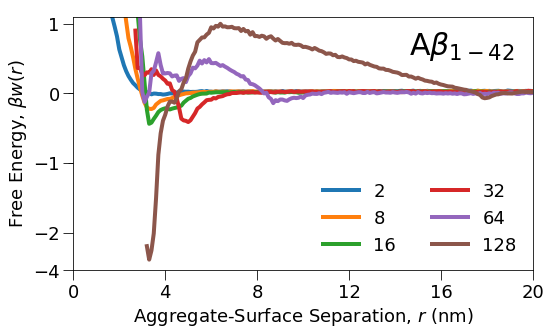

In [7]:
%cd -q $workdir

plt.rcParams.update({'font.size': 18, 'figure.figsize': [8, 5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['5KK3']:
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data[0.4].items(): # at 0.4 mol/l salt
        if N in fibril['numpep_range']:
            if type(d)!=type(float()):
                plt.plot( d['r']*0.1, d['pmf'], label=str(N), lw=4)

plt.legend(loc='lower right', frameon=False, fontsize='medium', ncol=2)
plt.xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
plt.ylabel(r'Free Energy, $\beta w(r)$')
plt.ylim((-4,1.1))
plt.xlim(0,20)
plt.xticks(np.arange(0,21,4))
plt.annotate(r'A$\beta_{1-42}$',xy=(0.73,.85), fontsize=30, xycoords='axes fraction')
plt.tight_layout()
plt.yscale('symlog')
plt.yticks([-4,-2,-1,0,1])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()

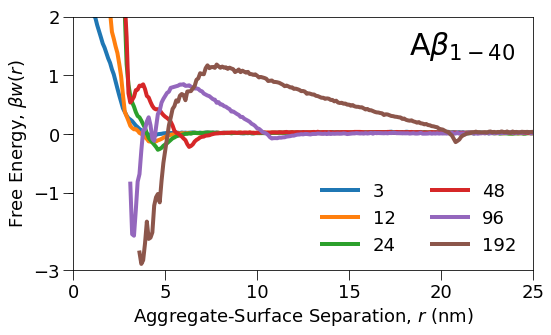

In [447]:
%cd -q $workdir

plt.rcParams.update({'font.size': 18, 'figure.figsize': [8, 5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['2M4J']:
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data[0.4].items(): # at 0.4 mol/l salt
        if N in fibril['numpep_range']:
            if type(d)!=type(float()):
                plt.plot( d['r']*0.1, d['pmf'], label=str(N), lw=4)

plt.legend(loc='lower right', frameon=False, fontsize='medium', ncol=2)
plt.xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
plt.ylabel(r'Free Energy, $\beta w(r)$')
plt.annotate(r'A$\beta_{1-40}$',xy=(0.73,.85), fontsize=30, xycoords='axes fraction')
plt.ylim((-3,2))
plt.xlim(0,25)
plt.yscale('symlog')
plt.yticks([-3,-1,0,1,2])
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.tight_layout()
plt.savefig('fig5_SI.eps')
plt.show()

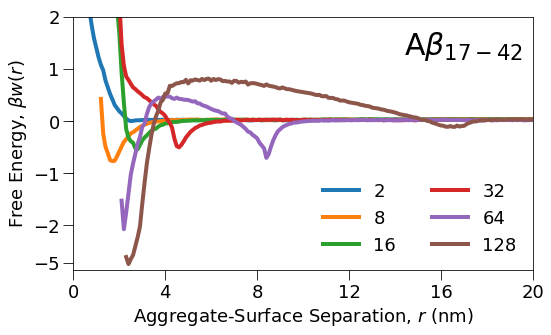

In [448]:
%cd -q $workdir

plt.rcParams.update({'font.size': 18, 'figure.figsize': [8, 5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['2BEG_17-42']:
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data[0.2].items(): # at 0.2 mol/l salt
        if N in fibril['numpep_range']:
            if type(d)!=type(float()):
                plt.plot( d['r']*0.1, d['pmf'], label=str(N), lw=4)

plt.legend(loc='lower right', frameon=False, fontsize='medium', ncol=2)
plt.xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
plt.ylabel(r'Free Energy, $\beta w(r)$')
plt.annotate(r'A$\beta_{17-42}$',xy=(0.72,.85), fontsize=30, xycoords='axes fraction')
plt.ylim((-6,2))
plt.xlim(0,20)
plt.xticks(np.arange(0,21,4))
plt.yscale('symlog')
plt.yticks([-5,-2,-1,0,1,2])
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.tight_layout()
plt.savefig('fig6_SI.eps')
plt.show()

### Henry's law constant

The following three cells plot the Henry's law constant, $K_{HA}$, obtained from MC simulations for aggregates of the different amyloid peptides.

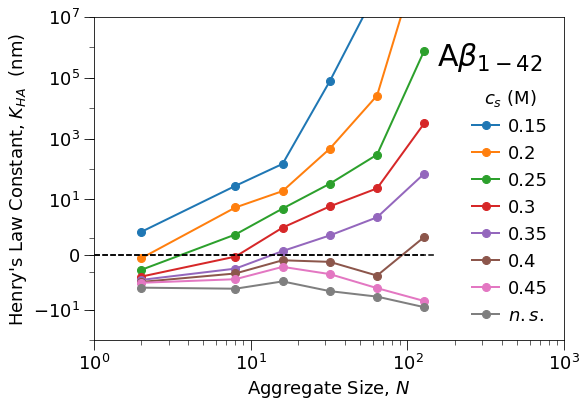

In [10]:
%cd -q $workdir
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8.5,6], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['5KK3']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for salt, d in data.iteritems():
        if str(salt) in ['0.15','0.2', '0.25', '0.3', '0.35', '0.4', '0.45','$n.s.$']:
            N = d.keys()    
            k = np.array( [ np.trapz( np.expm1(-i['pmf']), i['r']  ) for i in d.get_values() if type(i)==dict] )
            plt.plot(N, k*0.1, label=salt, linestyle='-', marker='o', lw=2, ms=8)
        
plt.plot( [0,128], [0,0], 'k--')
plt.legend(loc='lower right',frameon=False, fontsize='medium', 
           handlelength=1.5, handletextpad=0.5, title=r'$c_{s}$ (M)')
plt.ylim(-100,1e7)
plt.xlim(1,1000)
plt.plot( [0,150], [0,0], 'k--')
plt.xlabel(r'Aggregate Size, $N$')
plt.ylabel(r"Henry's Law Constant, $K_{HA}$  (nm)")
plt.xscale('log')
plt.yscale('symlog')
plt.yticks([-10,0,10,1e3,1e5,1e7])
plt.annotate(r'A$\beta_{1-42}$',xy=(0.73,.85), fontsize=30, xycoords='axes fraction')
plt.tight_layout()
plt.show()

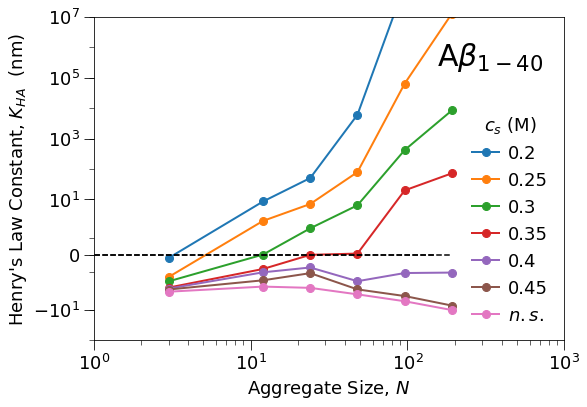

In [11]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8.5, 6], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['2M4J']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for salt, d in data.iteritems():
        if str(salt) in ['0.2', '0.25', '0.3', '0.35', '0.4', '0.45','$n.s.$']:
            N = d.keys()    
            k = np.array( [ np.trapz( np.expm1(-i['pmf']), i['r']  ) for i in d.get_values() if type(i)==dict] )
            plt.plot(N, k*0.1, label=salt, linestyle='-', marker='o', lw=2, ms=8)
        
plt.plot( [0,192], [0,0], 'k--')
plt.legend(loc='lower right',frameon=False, fontsize='medium', 
           handlelength=1.5, handletextpad=0.5, title=r'$c_{s}$ (M)')
plt.ylim(-100,1e7)
plt.xlim(1,1000)
plt.plot( [0,150], [0,0], 'k--')
plt.xlabel(r'Aggregate Size, $N$')
plt.ylabel(r"Henry's Law Constant, $K_{HA}$  (nm)")
plt.xscale('log')
plt.yscale('symlog')
plt.yticks([-10,0,10,1e3,1e5,1e7])
plt.annotate(r'A$\beta_{1-40}$',xy=(0.73,.85), fontsize=30, xycoords='axes fraction')
plt.tight_layout()
plt.show()

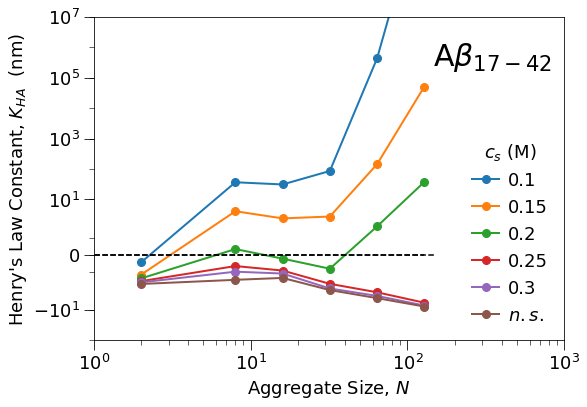

In [12]:
%cd -q $workdir
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8.5, 6], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

for name in ['2BEG_17-42']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for salt, d in data.iteritems():
        if str(salt) in ['0.1', '0.15', '0.2', '0.25', '0.3', '$n.s.$']:
            N = d.keys()    
            k = np.array( [ np.trapz( np.expm1(-i['pmf']), i['r']  ) for i in d.get_values() if type(i)==dict] )
            plt.plot(N, k*0.1, label=salt, linestyle='-', marker='o', lw=2, ms=8)
        
plt.plot( [0,128], [0,0], 'k--')
plt.legend(loc='lower right',frameon=False, fontsize='medium', 
           handlelength=1.5, handletextpad=0.5, title=r'$c_{s}$ (M)')
plt.ylim(-100,1e7)
plt.xlim(1,1000)
plt.plot( [0,150], [0,0], 'k--')
plt.xlabel(r'Aggregate Size, $N$')
plt.ylabel(r"Henry's Law Constant, $K_{HA}$  (nm)")
plt.xscale('log')
plt.yscale('symlog')
plt.yticks([-10,0,10,1e3,1e5,1e7])
plt.annotate(r'A$\beta_{17-42}$',xy=(0.72,.85), fontsize=30, xycoords='axes fraction')
plt.tight_layout()
plt.show()

## Line Segment Model

Here we calculate the surface excess using a simplified model, considering Gouy-Chapman electrostatics and the excluded volume of a rod approaching a planar surface. As detailed in the main text, the free energy can be approximated with
$$
\beta w(r)^{\scriptsize{\mbox{rod}}} \approx  2 z \ln \left[ \frac{1+\tanh (\beta \phi e /4)e^{-\frac{r}{\lambda_D}}}{1-\tanh (\beta \phi e /4)e^{-\frac{r}{\lambda_D}}} \right] - \ln(2r/L) \vee 0
+ (s/r)^{9}
$$
and Henry's law constants are obtained from the following integral
$$
K_{HA} = \int_{0}^{\infty} dr \left [ \exp (-\beta w(r)^{\scriptsize{\mbox{rod}}}) - 1 \right ].
$$
For A$\beta_{1-42}$ peptides, we set a net charge number per monomer of -3.
The length per monomer ($l_m$) and and the lower and upper bounds of the distance of closest approach ($s_0$ and $s_1$) are determined via a global least-square fit. For A$\beta_{1-42}$ peptides, $l_m$ is 2 Å, while $s_0$ and $s_1$ are 16 Å and 24 Å, respectively.

Here we define some useful variables and functions.

In [13]:
lB=7.1        # Bjerrum length (Å)
NA=6.022e23   # Avogadros number (1/mol)
sigma=1/266.  # surface charge density (Å-2)

# rod-to-surface excluded volume contribution to free energy (kT) 
def TdS(r, L):
    sel = r<0.5*L
    w   = -np.log(2*r[sel]/L)
    return np.concatenate((w, 0*r[~sel]))

# smooth function describing the dependece of the distance of closest approach on aggregate size (Å)
def dist(x,a,b,c):
    return a+(b-a)*np.tanh(x/c)

# Function to calculate Henry's constants from the line segment model
def henry_func(x,cs,s0,s1,m0):
    y = np.empty(0)
    for N in x:               # number of monomers
        L = N*lm              # rod length (Å)
        z = zm*N              # rod charge (e)
        s = dist(N,s0,s1,m0)
        lD = 3.04/sqrt(cs)    # Debye length (Å)
        phi = 2*asinh( 2*pi*sigma*lB*lD ) # surf. potential (kT/e)
        r = np.arange(s/3., 1000, 0.1)
        # surface-line electrostatic interaction
        # eq 62. DOI: http://dx.doi.org/10.1016/S0006-3495(02)75375-7
        w = 2 * z * np.log( ( 1 + np.tanh( phi / 4. ) * np.exp(-r/lD) ) 
                         / ( 1 - np.tanh( phi / 4. ) * np.exp(-r/lD) ) ) + TdS(r,L) + (s/r)**9
        # Henry's law constant
        k = np.trapz( np.expm1(-w), r )*.1
        y = np.append(y,k)
    return y

# Function to fit the MC data to the line segment model
# The fitting parameters are:
# s0 and s1:  are the lower and upper bounds of the distance of closest approach, s, for aggregates of increasing size, N
# m0: constant determining the steepness of the smooth function describing the increase of s with increasing N
# lm: the length per monomer of the aggregate 
def leastsq_function(params, *args):
    s0 = params[0]
    s1 = params[1]
    m0 = params[2]
    x = args[0]
    y = args[1]
    salt = args[2]
    pts = int(y.size / salt.size)
    yfit = np.empty(x.shape)
    for i in range(salt.size):
        yfit[pts*i:pts*(i+1)] = henry_func(x[pts*i:pts*(i+1)], salt[i], s0, s1, m0)
    return np.power((y - yfit),2).sum()

### A$\beta_{1-42}$ peptides

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 37.888492239289846
            Iterations: 33
            Function evaluations: 176
            Gradient evaluations: 33
[ 16.96692935  24.19576167  91.80931301]


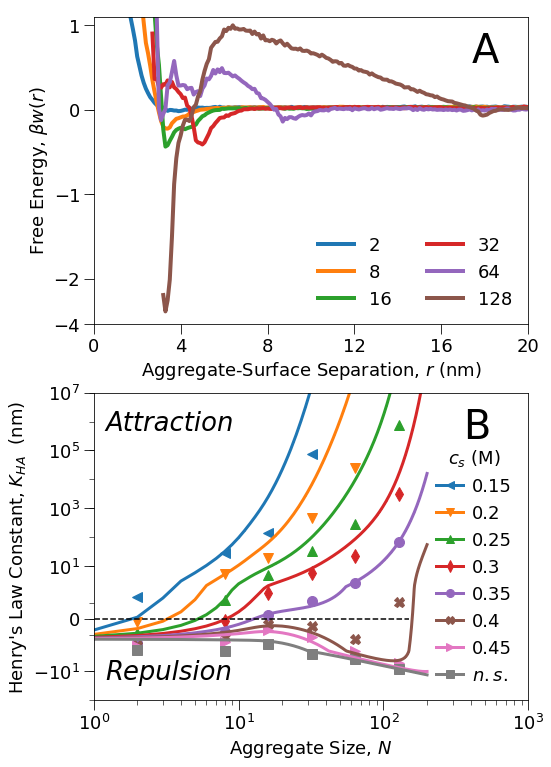

In [355]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8, 11], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})
%cd -q $workdir

f, ((ax1, ax2)) = plt.subplots(2, 1, sharex=False, sharey=False)

for name in ['5KK3']:
    fibril = fibrils[name]
    data = pd.read_pickle('mc/'+name+'-data.p')
    for N, d in data[0.4].items(): # at 0.4 mol/l salt
        if N in fibril['numpep_range']:
            if type(d)!=type(float()):
                ax1.plot( d['r']*0.1, d['pmf'], label=str(N), lw=4)

ax1.legend(loc='lower right', frameon=False, fontsize='medium', ncol=2)
ax1.set_xlabel(r'Aggregate-Surface Separation, $r$ (nm)')
ax1.set_ylabel(r'Free Energy, $\beta w(r)$')
ax1.set_ylim((-4,1.1))
ax1.set_xlim(0,20)
ax1.set_xticks(np.arange(0,21,4))
ax1.annotate('A',xy=(0.87,.85), fontsize=40, xycoords='axes fraction')
ax1.set_yscale('symlog')
ax1.set_yticks([-4,-2,-1,0,1])
ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

###########################################################
##################   amyloid-beta 1-42   ##################
###########################################################

zm=-3         # monomer charge (e)
lm=2.8
n = np.linspace(1, 200, 200) # number of monomers
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
marker = ['<','v','^','d','o','X','>','s','x','>']

salt = np.array([.35,.4,.45])
henrys = np.empty(0)
aggsize = np.empty(0)
for name in ['5KK3']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for cs, d in data.iteritems():
        if cs in salt:
            N = d.keys() 
            k = np.array( [ np.trapz( np.expm1(-i['pmf']), i['r']  ) for i in d.get_values() if type(i)==dict] )*.1
            aggsize = np.append(aggsize,N)
            henrys = np.append(henrys,k)
            #plt.plot(N, k, marker='o', lw=0, ms=8, color=c)

x0 = [6.5,23.9,50]
args = (aggsize, henrys, salt)
result = optimize.fmin_slsqp(leastsq_function,x0,args=args,bounds=[(10,20),(20,30),(50,100)])
print(result)

salt = np.array([.15,.2,.25,.3,.35,.4,.45,1e10])
for name in ['5KK3']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for cs, d in data.iteritems():
        if cs=='$n.s.$':
            cs=1e10
        if cs in salt:
            c = color[salt.tolist().index(cs)]
            m = marker[salt.tolist().index(cs)]
            N = d.keys() 
            k = np.array( [ np.trapz( np.expm1(-i['pmf']), i['r']  ) for i in d.get_values() if type(i)==dict] )*.1
            ax2.plot(N, k, marker=m, lw=0, ms=10, color=c)
for cs in salt:
    c = color[salt.tolist().index(cs)]
    m = marker[salt.tolist().index(cs)]
    n = np.linspace(1, 200, 200) # number of monomers
    cslabel = str(cs)
    if cs==1e10:
        cslabel='$n.s.$'
    ax2.plot(n,henry_func(n,cs,result[0],result[1],result[2]), label=cslabel, 
             linestyle='-', lw=3, color=c, marker=m, ms=.1)   
            
ax2.legend(loc='lower right',frameon=False, fontsize='medium', 
           handlelength=1.5, handletextpad=0.5, title=r'$c_{s}$ (M)',markerscale=80)
ax2.set_ylim(-100,1e7)
ax2.set_xlim(1,1000)
ax2.plot( [0,150], [0,0], 'k--')
ax2.set_xlabel(r'Aggregate Size, $N$')
ax2.set_ylabel(r"Henry's Law Constant, $K_{HA}$  (nm)")
ax2.set_xscale('log')
ax2.set_yscale('symlog')
ax2.set_yticks([-10,0,10,1e3,1e5,1e7])
ax2.text(1.2,5e5,'Attraction',rotation='0', color='k',fontsize='x-large', style='italic')
ax2.text(1.2,-19,'Repulsion',rotation='0',color='k',fontsize='x-large', style='italic')
ax2.annotate('B',xy=(0.85,.85), fontsize=40, xycoords='axes fraction')
plt.tight_layout(h_pad=0)
plt.savefig('fig3.eps')
plt.show()

### A$\beta_{1-40}$ peptides and A$\beta_{17-42}$ peptides

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 43.183031686764025
            Iterations: 19
            Function evaluations: 108
            Gradient evaluations: 19
[   19.30445454    72.6839804   1555.68915803]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.080311898199218
            Iterations: 70
            Function evaluations: 371
            Gradient evaluations: 70
[  20.28418284   27.78193886  208.31040239]


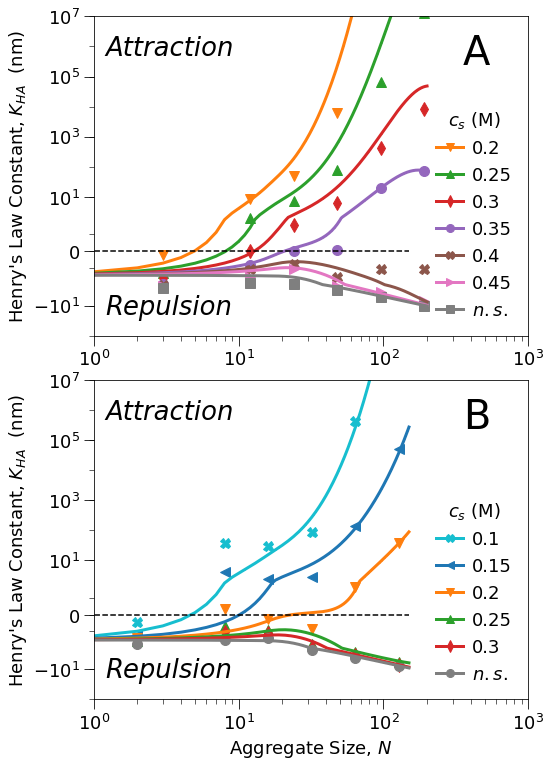

In [354]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8, 11], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})
%cd -q $workdir

f, ((ax1, ax2)) = plt.subplots(2, 1, sharex=False, sharey=False)

###########################################################
##################   amyloid-beta 1-40   ##################
###########################################################

zm=-3     # monomer charge (e)
lm=2.2
n = np.linspace(1, 200, 200) # number of monomers
color = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
marker = ['v','^','d','o','X','>','s','x','>']

salt = np.array([.35,.4,.45])
henrys = np.empty(0)
aggsize = np.empty(0)
for name in ['2M4J']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for cs, d in data.iteritems():
        if cs in salt:
            N = d.keys() 
            c = color[salt.tolist().index(cs)]
            k = np.array( [ np.trapz( np.expm1(-i['pmf']), i['r']  ) for i in d.get_values() if type(i)==dict] )*.1
            aggsize = np.append(aggsize,N)
            henrys = np.append(henrys,k)

x0 = [19.7,47.8,1e3]
args = (aggsize, henrys, salt)
result = optimize.fmin_slsqp(leastsq_function,x0,args=args,bounds=[(18,22),(40,1e2),(1e2,3e3)])
print(result)

salt = np.array([.2,.25,.3,.35,.4,.45,1e10])
henrys = np.empty(0)
aggsize = np.empty(0)
for name in ['2M4J']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for cs, d in data.iteritems():
        if cs=='$n.s.$':
            cs=1e10
        if cs in salt:
            c = color[salt.tolist().index(cs)]
            m = marker[salt.tolist().index(cs)]
            N = d.keys() 
            k = np.array( [ np.trapz( np.expm1(-i['pmf']), i['r']  ) for i in d.get_values() if type(i)==dict] )*.1
            aggsize = np.append(aggsize,N)
            henrys = np.append(henrys,k)
            ax1.plot(N, k, marker=m, lw=0, ms=10, color=c)

for cs in salt:
    c = color[salt.tolist().index(cs)]
    m = marker[salt.tolist().index(cs)]
    n = np.linspace(1, 200, 200) # number of monomers
    cslabel = str(cs)
    if cs==1e10:
        cslabel='$n.s.$'
    ax1.plot(n,henry_func(n,cs,result[0],result[1],result[2]), label=cslabel, 
             linestyle='-', lw=3, color=c, marker=m, ms=.1)   
    
ax1.legend(loc='lower right',frameon=False, fontsize='medium', 
           handlelength=1.5, handletextpad=0.5, title=r'$c_{s}$ (M)',markerscale=80)
ax1.set_ylim(-100,1e7)
ax1.set_xlim(1,1000)
ax1.plot( [0,150], [0,0], 'k--')
ax1.set_ylabel(r"Henry's Law Constant, $K_{HA}$  (nm)")
ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.set_yticks([-10,0,10,1e3,1e5,1e7])
ax1.text(1.2,5e5,'Attraction',rotation='0', color='k',fontsize='x-large', style='italic')
ax1.text(1.2,-19,'Repulsion',rotation='0',color='k',fontsize='x-large', style='italic')
ax1.annotate('A',xy=(0.85,.85), fontsize=40, xycoords='axes fraction')
############################################################
##################   amyloid-beta 17-42   ##################
############################################################
zm=-1     # monomer charge (e)
lm=2.6
n = np.linspace(1, 150, 150) # number of monomers
color = ['#17becf','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#7f7f7f', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']
marker = ['X','<','v','^','d','o','X','>','s','x','>']

salt = np.array([.2,.25,.3])
henrys = np.empty(0)
aggsize = np.empty(0)
for name in ['2BEG_17-42']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for cs, d in data.iteritems():
        if cs in salt:
            N = d.keys() 
            c = color[salt.tolist().index(cs)]
            k = np.array( [ np.trapz( np.expm1(-i['pmf']), i['r']  ) for i in d.get_values() if type(i)==dict] )*.1
            aggsize = np.append(aggsize,N)
            henrys = np.append(henrys,k)

x0 = [ 6.09187063,25.71537969,19.12078671]
args = (aggsize, henrys, salt)
result = optimize.fmin_slsqp(leastsq_function,x0,args=args,bounds=[(10,25),(20,30),(60,400)])
print(result)

salt = np.array([.1,.15,.2,.25,.3,1e10])
henrys = np.empty(0)
aggsize = np.empty(0)
for name in ['2BEG_17-42']:
    fibril = fibrils[name]
    data = pd.read_pickle(workdir+'/mc/'+name+'-data.p')
    for cs, d in data.iteritems():
        if cs=='$n.s.$':
            cs=1e10
        if cs in salt:
            c = color[salt.tolist().index(cs)]
            m = marker[salt.tolist().index(cs)]
            N = d.keys() 
            k = np.array( [ np.trapz( np.expm1(-i['pmf']), i['r']  ) for i in d.get_values() if type(i)==dict] )*.1
            aggsize = np.append(aggsize,N)
            henrys = np.append(henrys,k)
            plt.plot(N, k, marker=m, lw=0, ms=10, color=c)
for cs in salt:
    c = color[salt.tolist().index(cs)]
    m = marker[salt.tolist().index(cs)]
    cslabel = str(cs)
    if cs==1e10:
        cslabel='$n.s.$'
    plt.plot(n,henry_func(n,cs,result[0],result[1],result[2]), label=cslabel, 
             linestyle='-', lw=3, color=c, marker=m, ms=.1)  
            
ax2.legend(loc='lower right',frameon=False, fontsize='medium', 
           handlelength=1.5, handletextpad=0.5, title=r'$c_{s}$ (M)',markerscale=80)
ax2.set_ylim(-100,1e7)
ax2.set_xlim(1,1000)
ax2.plot( [0,150], [0,0], 'k--')
ax2.set_xlabel(r'Aggregate Size, $N$')
ax2.set_ylabel(r"Henry's Law Constant, $K_{HA}$  (nm)")
ax2.set_xscale('log')
ax2.set_yscale('symlog')
ax2.set_yticks([-10,0,10,1e3,1e5,1e7])
ax2.text(1.2,5e5,'Attraction',rotation='0', color='k',fontsize='x-large', style='italic')
ax2.text(1.2,-19,'Repulsion',rotation='0',color='k',fontsize='x-large', style='italic')
ax2.annotate('B',xy=(0.85,.85), fontsize=40, xycoords='axes fraction')
plt.tight_layout(h_pad=0)
plt.savefig('fig4.eps')
plt.show()

# Generalized van der Walls model: Surface Excess and Adsorbed Amount

The surface excess of the aggregates is given by the implicit equation
$$
\Gamma = K_{HA} \frac{\rho}{N} \left (1-\frac{3N\Gamma}{\sigma}\right )\exp \left (2\Gamma\hat{a}-\frac{3N\Gamma}{\sigma - 3N\Gamma} \right )
$$
where $\hat{a}$ is the mean-field energy constant for the adsorbed aggregates
$$
\hat{a} = - \frac{1}{2}\int_s^\infty dr 2\pi r \beta w(r)_{\scriptsize{\mbox{surface}}}.
$$
The implicit equation is solved numerically using $brenth$, a variation on the classic Brent routine implemented in the scipy module.

It has previously been shown that highly charged rod-like polyelectrolytes release only a small fraction of condensed counterions upon adsorption onto a weakly charged surface of opposite sign (Cheng, H.; de la Cruz, M.O. Adsorption of rod-like polyelectrolytes onto weakly charged surfaces. The Journal of Chemical Physics 2003, 119, 12635–12644).

From MC simulations (see Counterion Condensation and Compesation of Linear Charge Density), we estimate that the effective charge number per monomer for A$\beta_{1-40}$ is $z_m=-1.35$.

In [16]:
s0 = 19.3 # distance of closest approach for small aggregates
s1 = 72.7 # distance of closest approach for large aggregates
m0 = 1556. # constant determining the steepness of the smooth function describing the increase of s with increasing N
lm = 2.2 # length per monomer
zm = -1.35

def args(N, salt):
    L = N*lm              # rod length (Å)
    z = zm*N              # rod charge (e)
    lD = 3.04/sqrt(salt)  # Debye length (Å)
    s = dist(N,s0,s1,m0)
    phi = 2*asinh( sigma*2*pi*lD*lB ) # surf. potential (kT/e)
    r = np.arange(s, 1000, 0.1)
    w_surf = 2*z*z*lB*k0(r/lD)/L + (s/r)**12
    w_surf = 0
    a_hat = -pi*np.trapz( w_surf*r, r )*1e-2 
    r = np.arange(1e-10, 1000, 0.1)
    w = 2 * z * np.log( ( 1 + np.tanh( phi / 4. ) * np.exp(-r/lD) ) 
                             / ( 1 - np.tanh( phi / 4. ) * np.exp(-r/lD) ) ) + TdS(r,L) + (s/r)**9
    k = np.trapz( np.expm1(-w), r )*.1
    return (N,k,a_hat)
    
def exc(x,N,k,a_hat):    
    sigma = 100/266      # surface charge density (nm-2)
    return -x + k*rho/N*(1.-3*N*x/sigma)*np.exp(2*x*a_hat-3*N*x/(sigma-3*N*x))

x = np.linspace(0.05,0.4, 401) # salt concentration
y = np.linspace(1,650,650) # number of monomers
Z = np.ndarray(shape=(y.size,x.size))
rho = 2.4*1e-6     # conc of the bulk solution (nm-3)
for N in y:                   # number of monomers
    for salt in x:            # ionic strength (mol/l)
        b = brenth(exc, a=-1e-5, b=100, args=args(N, salt),maxiter=200)
        Z[y.tolist().index(N)][x.tolist().index(salt)] = b*1e3

The surface excess of the aggregates is converted into adsorbed amount:
$$
\Delta m = N \Gamma M_W / N_A
$$
where $M_W$ is the molecular weight of the A$\beta_{1-40}$ peptide.

In [17]:
x = np.linspace(0.05,0.4, 401) # salt concentration
y = np.linspace(1,650,650) # number of monomers
M = np.ndarray(shape=(y.size,x.size))
mass50mM = np.empty(0)
mass100mM = np.empty(0)
mass150mM = np.empty(0)
mass200mM = np.empty(0)
gamma50mM = np.empty(0)
gamma100mM = np.empty(0)
gamma150mM = np.empty(0)
gamma200mM = np.empty(0)
rho = 2.4*1e-6     # conc of the bulk solution (nm-3)
for N in y:                   # number of monomers
    for salt in x:            # ionic strength (mol/l)
        c = N*4.3298/6.022
        M[y.tolist().index(N)][x.tolist().index(salt)] = Z[y.tolist().index(N)][x.tolist().index(salt)]*c
        if salt==0.05:
            mass50mM = np.append( mass50mM, Z[y.tolist().index(N)][x.tolist().index(salt)]*c )
            gamma50mM = np.append( gamma50mM, Z[y.tolist().index(N)][x.tolist().index(salt)] )
        if round(salt,3)==0.1:
            mass100mM = np.append( mass100mM, Z[y.tolist().index(N)][x.tolist().index(salt)]*c )
            gamma100mM = np.append( gamma100mM, Z[y.tolist().index(N)][x.tolist().index(salt)] )
        if round(salt,3)==0.15:
            mass150mM = np.append( mass150mM, Z[y.tolist().index(N)][x.tolist().index(salt)]*c )
            gamma150mM = np.append( gamma150mM, Z[y.tolist().index(N)][x.tolist().index(salt)] )
        if round(salt,4)==0.2005:
            mass200mM = np.append( mass200mM, Z[y.tolist().index(N)][x.tolist().index(salt)]*c )
            gamma200mM = np.append( gamma200mM, Z[y.tolist().index(N)][x.tolist().index(salt)] )

The surface excess and adsorbed amount are plotted as functions of ionic strength and aggregate size.

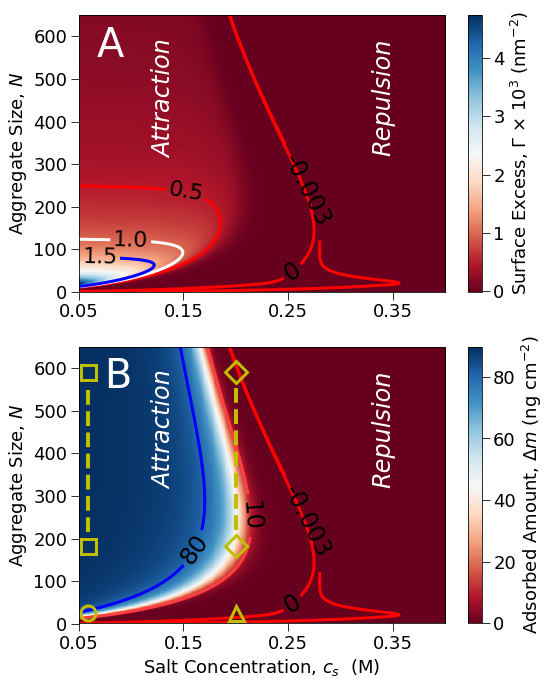

In [730]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8, 10]})

f, ((ax1, ax2)) = plt.subplots(2, 1, sharex=False, sharey=False)
vmin=Z.min()
vmax=Z.max()

im = ax1.imshow(Z,cmap=cm.RdBu,extent=[x.min(),x.max(),y.min(),y.max()],origin='lower',aspect='auto', 
                vmin=vmin, vmax=vmax) 

# contour lines
cset = ax1.contour(x, y, Z, [.5,1,1.5], linewidths=3, cmap=cm.bwr_r)
manual_locations = [(0.15, 180),(0.1, 150),(0.07,80)]
ax1.clabel(cset, inline=True, fmt='%1.1f', fontsize=22, manual=manual_locations,colors=['k','k','k'])

cset = ax1.contour(x, y, M, [0], linewidths=3, cmap=cm.bwr_r)
manual_locations = [(0.25, 70)]
ax1.clabel(cset, inline=True, fmt='%1.f', fontsize=24, manual=manual_locations,colors=['k'])

cset = ax1.contour(x, y, M, [-.003], linewidths=3, cmap=cm.bwr_r)
manual_locations = [(0.3, 300)]
ax1.clabel(cset, inline=True, fmt='%1.3f', fontsize=24, manual=manual_locations,colors=['k'])

ax1.text(0.120,550,'Attraction',rotation='90', color='white',fontsize=24, style='italic')
ax1.text(0.33,550,'Repulsion',rotation='90',color='white',fontsize=24, style='italic')

# labels
colorbar(im,ax=ax1,ticks=np.arange(0,6.5,1),label=r'Surface Excess, $\Gamma$ $\times$ 10$^3$ (nm$^{-2}$)') # adding the colorbar on the right
ax1.set_ylabel('Aggregate Size, $N$')
ax1.set_xticks(np.arange(.05,.52,.1))
ax1.annotate('A',xy=(0.05,.85), fontsize=40, xycoords='axes fraction',color='w')
ax1.set_xlim(.05,.4)

####################################################

vmin=M.min()
vmax=M.max()

im = ax2.imshow(M,cmap=cm.RdBu,extent=[x.min(),x.max(),y.min(),y.max()],origin='lower',aspect='auto', 
                vmin=vmin, vmax=vmax) 

# contour lines
cset = ax2.contour(x, y, M, [0,10,80], linewidths=3, cmap=cm.bwr_r)
manual_locations = [(0.25, 70),(0.2, 250),(0.15, 200)]
ax2.clabel(cset, inline=True, fmt='%1.f', fontsize=24, manual=manual_locations,colors=['k','k','k'])

cset = ax2.contour(x, y, M, [-.003], linewidths=3, cmap=cm.bwr_r)
manual_locations = [(0.3, 300)]
ax2.clabel(cset, inline=True, fmt='%1.3f', fontsize=24, manual=manual_locations,colors=['k'])

ax2.text(0.120,550,'Attraction',rotation='90', color='white',fontsize=24, style='italic')
ax2.text(0.33,550,'Repulsion',rotation='90',color='white',fontsize=24, style='italic')

#plt.scatter([.05,.2,.05,.2], [150,150,1,1], s=500, c='k', alpha=0,edgecolors='k')
ax2.plot( [.059], [591], 's', ms=15, mew=3, mec='y', mfc='None')
ax2.plot( [.2], [591], 'D', ms=15, mew=3, mec='y', mfc='None')
ax2.plot( [.059], [182], 's', ms=15, mew=3, mec='y', mfc='None')
ax2.plot( [.2], [182], 'D', ms=15, mew=3, mec='y', mfc='None')
ax2.plot( [.059], [25], 'o', ms=15, mew=3, mec='y', mfc='None')
ax2.plot( [.2], [25], '^', ms=15, mew=3, mec='y', mfc='None')
ax2.vlines(x=.2,ymin=220,ymax=565,linestyles='--',lw=4,color='y')
ax2.vlines(x=.059,ymin=215,ymax=560,linestyles='--',lw=4,color='y')
# labels
colorbar(im,ax=ax2,ticks=np.arange(0,135,20),label=r'Adsorbed Amount, $\Delta m$ (ng cm$^{-2}$)') # adding the colorbar on the right
ax2.set_ylabel('Aggregate Size, $N$')
ax2.set_xlabel('Salt Concentration, $c_s$  (M)')
ax2.set_xticks(np.arange(.05,.52,.1))
ax2.annotate('B',xy=(0.07,.85), fontsize=40, xycoords='axes fraction',color='w')
ax2.set_xlim(.05,.4)
ax2.set_ylim(1,650)
plt.tight_layout(h_pad=0)
plt.savefig('fig6.eps')
plt.show()

The surface excess is plotted as a function of aggregate size for three ionic strengths.

max adsorbed amount at 0.15 M for L= [ 70.62] nm
max surface excess at 0.15 M for L= [ 20.46] nm


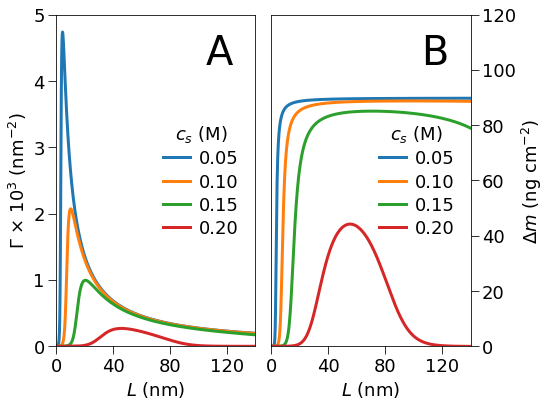

In [441]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8.0, 6]})
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex=False, sharey=False)

ax1.plot(y*0.22,gamma50mM, label='0.05', linestyle='-', lw=3)
ax1.plot(y*0.22,gamma100mM, label='0.10', linestyle='-', lw=3)
ax1.plot(y*0.22,gamma150mM, label='0.15', linestyle='-', lw=3)
ax1.plot(y*0.22,gamma200mM, label='0.20', linestyle='-', lw=3)
ax1.set_xlim(0,140)
ax1.set_ylim(0,5)
ax1.set_xticks(np.arange(0,150,40))
ax1.set_ylabel(r'$\Gamma$ $\times$ 10$^3$ (nm$^{-2}$)')

ax1.set_xlabel('$L$ (nm)')
ax1.legend(loc='center right',frameon=False, fontsize='medium', labelspacing=.3,
           handlelength=1.5, handletextpad=0.5, title=r'$c_{s}$ (M)',markerscale=80)
print('max adsorbed amount at 0.15 M for L=', y[mass150mM==mass150mM.max()]*.22,'nm')

ax2.plot(y*.22,mass50mM, label='0.05', linestyle='-', lw=3)
ax2.plot(y*.22,mass100mM, label='0.10', linestyle='-', lw=3)
ax2.plot(y*.22,mass150mM, label='0.15', linestyle='-', lw=3)
ax2.plot(y*.22,mass200mM, label='0.20', linestyle='-', lw=3)
ax2.set_xlim(0,140)
ax2.set_ylim(0,120)
ax2.set_xticks(np.arange(0,150,40))
ax2.set_xlabel('$L$ (nm)')
ax2.set_ylabel('$\Delta m$ (ng cm$^{-2}$)')
ax2.legend(loc='center right',frameon=False, fontsize='medium', labelspacing=.3,
           handlelength=1.5, handletextpad=0.5, title=r'$c_{s}$ (M)',markerscale=80)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
print('max surface excess at 0.15 M for L=', y[gamma150mM==gamma150mM.max()]*.22,'nm')
ax1.annotate('A',xy=(0.75,.85), fontsize=40, xycoords='axes fraction')
ax2.annotate('B',xy=(0.75,.85), fontsize=40, xycoords='axes fraction')
plt.tight_layout(w_pad=0)
plt.savefig('fig7.eps', bbox_inches='tight', pad_inches=0.3)
plt.show()

# Quartz Crystal Microbalance Dissipation (QCM-D) data

In this section we load and plot the QCM-D data.

In [20]:
F50mon = np.loadtxt('exp/50mon.dat',comments={'T'},usecols=(0,1,3,5))
D50mon = np.loadtxt('exp/50mon.dat',comments={'T'},usecols=(0,2,4,6))

F200fib = np.loadtxt('exp/200fib.dat',comments={'T'},usecols=(0,3,5,7))
D200fib = np.loadtxt('exp/200fib.dat',comments={'T'},usecols=(0,4,6,8))

F200mon = np.loadtxt('exp/200mon.dat',comments={'T'},usecols=(0,1,3,5))
D200mon = np.loadtxt('exp/200mon.dat',comments={'T'},usecols=(0,2,4,6))

F50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,1,5,9,13))
D50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,3,7,11,15))
Fit50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,2,4,6,8,10,12,14,16))
vis50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,17,20,23))
shear50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,18,21,24))
mass50fib = np.loadtxt('exp/50fib_1.dat',comments={'T'},usecols=(0,19,22,25))

F50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,1,5,9,13))
D50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,3,7,11,15))
Fit50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,2,4,6,8,10,12,14,16))
vis50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,17,20,23))
shear50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,18,21,24))
mass50fib2 = np.loadtxt('exp/50fib_2.dat',comments={'T'},usecols=(0,19,22,25))

mass50fib[:,1:] = mass50fib[:,1:]/100
vis50fib[:,1:] = vis50fib[:,1:]
shear50fib[:,1:] = shear50fib[:,1:]/100

mass50fib2[:,1:] = mass50fib2[:,1:]/100
vis50fib2[:,1:] = vis50fib2[:,1:]
shear50fib2[:,1:] = shear50fib2[:,1:]/100

Fslb = np.loadtxt('exp/slb.dat',comments={'T'},usecols=(0,1,3,5,7,9))
Dslb = np.loadtxt('exp/slb.dat',comments={'T'},usecols=(0,2,4,6,8,10))

In [21]:
F50monPOPC = np.loadtxt('exp/20100531_POPC_Ab40_monomer_s4.txt',comments={'T'},usecols=(0,3,5,7,9))
D50monPOPC = np.loadtxt('exp/20100531_POPC_Ab40_monomer_s4.txt',comments={'T'},usecols=(0,4,6,8,10))

F50monDOTAP = np.loadtxt('exp/20120516_3POPC1DOTAP_Ab40_monomer_s1.txt',comments={'T'},usecols=(0,3,5,7,9))
D50monDOTAP = np.loadtxt('exp/20120516_3POPC1DOTAP_Ab40_monomer_s1.txt',comments={'T'},usecols=(0,4,6,8,10))

F200monDOTAP = np.loadtxt('exp/20160524_3POPC1DOTAP_Ab40_150mM_monomer_s3.txt',comments={'T'},usecols=(0,3,5,7,9))
D200monDOTAP = np.loadtxt('exp/20160524_3POPC1DOTAP_Ab40_150mM_monomer_s3.txt',comments={'T'},usecols=(0,4,6,8,10))

F200fibDOTAP = np.loadtxt('exp/20150619_3POPC1DOTAP_Ab40_150mM_fibril_s4.txt',comments={'T'},usecols=(0,3,5,7,9))
D200fibDOTAP = np.loadtxt('exp/20150619_3POPC1DOTAP_Ab40_150mM_fibril_s4.txt',comments={'T'},usecols=(0,4,6,8,10))

F50fibPOPC = np.loadtxt('exp/20120530_POPC_Ab40_fibril_batch1_s1.txt',comments={'T'},usecols=(0,3,5,7,9))
D50fibPOPC = np.loadtxt('exp/20120530_POPC_Ab40_fibril_batch1_s1.txt',comments={'T'},usecols=(0,4,6,8,10))

F50fibDOTAP = np.loadtxt('exp/20120530_3POPC1DOTAP_Ab40_fibril_batch1_s3.txt',comments={'T'},usecols=(0,3,5,7,9))
D50fibDOTAP = np.loadtxt('exp/20120530_3POPC1DOTAP_Ab40_fibril_batch1_s3.txt',comments={'T'},usecols=(0,4,6,8,10))

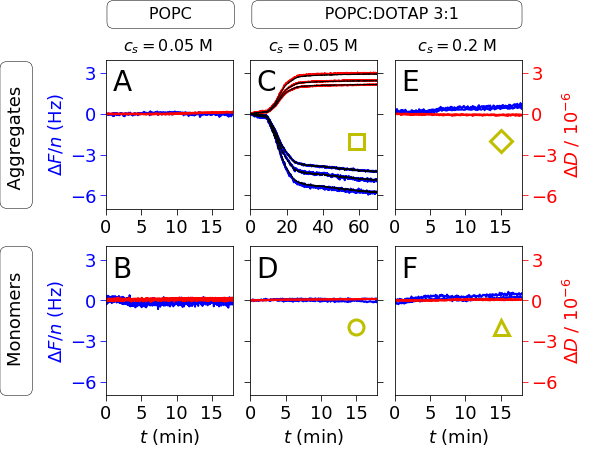

In [374]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8, 6], 
                     'xtick.minor.size':3, 'xtick.major.size':6, 'ytick.minor.size':3, 'ytick.major.size':6})
f = plt.figure()

xticks = np.arange(0,16,5)
yticks = np.array([-6,-3,0,3])

f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3)

# 50 mM fibrils POPC
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.tick_params(axis='y',colors='b')
ax1.set_ylim(-7,4)
ax1.set_xlim(0,18)
ax1.set_ylabel("$\Delta F/n$ (Hz)",color='blue')
idx = find_nearest(F50fibPOPC[:,0],0)
ax1.plot(F50fibPOPC[idx:,0]/60,F50fibPOPC[idx:,2:],color='blue', lw=2)
ax1.plot(D50fibPOPC[idx:,0]/60,D50fibPOPC[idx:,2:],color='red', lw=2)
ax1.text(-14,2.3,'  Aggregates   ',rotation=90,fontsize = 18,zorder = 6, color = 'k', multialignment='center',
        bbox={'ec':'k','facecolor':'white', 'lw':.5, 'boxstyle':'round,pad=0.4'})
ax1.text(1.05,7, '       POPC       ',fontsize = 16,zorder = 6, color = 'k', multialignment='center',
                bbox={'ec':'k','facecolor':'white', 'lw':.5, 'boxstyle':'round,pad=0.4'})
ax1.text(1,4.6, '  $c_s = 0.05$ M  ',fontsize = 16,zorder = 6, color = 'k', multialignment='center',
                bbox={'ec':'k','facecolor':'white', 'alpha':0, 'lw':0, 'boxstyle':'round,pad=0.4'})

# 50 mM fibrils POPC:DOTAP
ax2.set_xticks(np.arange(0,70,20))
ax2.set_yticks(yticks)
ax2.set_yticklabels(np.tile([''],yticks.size))
ax2.set_ylim(-7,4)
ax2.set_xlim(0,70)
ax2.yaxis.set_ticks_position('both')
ax2.plot(F50fib[:,0]/60,F50fib[:,2:],color='blue', lw=2)
ax2.plot(D50fib[:,0]/60,D50fib[:,2:],color='red', lw=2)
ax2.plot(Fit50fib[:,0]/60,Fit50fib[:,3:],color='black', lw=1)
ax2.plot( [58], [-2], 's', ms=15, mew=3, mec='y', mfc='None')
ax2.text(4.35,7, '             POPC:DOTAP 3:1           ',fontsize = 16,zorder = 6, color = 'k', multialignment='center',
                bbox={'ec':'k','facecolor':'white', 'lw':.5, 'boxstyle':'round,pad=0.4'})
ax2.text(4.1,4.6, '  $c_s = 0.05$ M  ',fontsize = 16,zorder = 6, color = 'k', multialignment='center',
                bbox={'ec':'white','facecolor':'white', 'alpha':0, 'lw':0, 'boxstyle':'round,pad=0.4'})

# 200 mM fibrils POPC:DOTAP
ax3.set_xticks(xticks)
ax3.set_yticks(yticks)
ax3.tick_params(axis='y',colors='r')
ax3.set_ylim(-7,4)
ax3.set_xlim(0,18)
ax3.yaxis.tick_right()
ax3.set_ylabel("$\Delta D$ / 10$^{-6}$",color='red')
ax3.yaxis.set_label_position("right")
ax3.plot(F200fib[:,0]/60,F200fib[:,2:],color='blue', lw=2)
ax3.plot(D200fib[:,0]/60,D200fib[:,2:],color='red', lw=2)
ax3.plot( [15], [-2], 'D', ms=15, mew=3, mec='y', mfc='None')
ax3.text(1,4.6, '   $c_s = 0.2$ M   ',fontsize = 16,zorder = 6, color = 'k', multialignment='center',
                bbox={'ec':'white','facecolor':'white', 'alpha':0, 'lw':0,'boxstyle':'round,pad=0.4'})

# 50 mM monomer POPC
ax4.set_xticks(xticks)
ax4.set_yticks(yticks)
ax4.tick_params(axis='y',colors='b')
ax4.set_ylim(-7,4)
ax4.set_xlim(0,18)
ax4.set_ylabel("$\Delta F/n$ (Hz)",color='blue')
ax4.set_xlabel("$t$ (min)")
idx = find_nearest(F50monPOPC[:,0],0)
ax4.plot(F50monPOPC[idx:,0]/60,F50monPOPC[idx:,2:],color='blue', lw=2)
ax4.plot(D50monPOPC[idx:,0]/60,D50monPOPC[idx:,2:],color='red', lw=2)
ax4.text(-14,2.4,'    Monomers   ',rotation=90,fontsize = 18,zorder = 6, color = 'k', multialignment='center',
        bbox={'ec':'k','facecolor':'white', 'lw':.5, 'boxstyle':'round,pad=0.4'})

# 50 mM monomers POPC:DOTAP
ax5.set_xticks(xticks)
ax5.set_yticks(yticks)
ax5.set_yticklabels(np.tile([''],yticks.size))
ax5.set_ylim(-7,4)
ax5.set_xlim(0,18)
ax5.yaxis.set_ticks_position('both')
ax5.set_xlabel("$t$ (min)")
ax5.plot(F50mon[:,0]/60,F50mon[:,2:],color='blue', lw=2)
ax5.plot(D50mon[:,0]/60,D50mon[:,2:],color='red', lw=2)
ax5.plot( [15], [-2], 'o', ms=15, mew=3, mec='y', mfc='None')

# 200 mM monomers POPC:DOTAP
ax6.set_xticks(xticks)
ax6.set_yticks(yticks)
ax6.tick_params(axis='y',colors='r')
ax6.set_ylim(-7,4)
ax6.set_xlim(0,18)
ax6.set_ylabel("$\Delta D$ / 10$^{-6}$",color='red')
ax6.yaxis.set_label_position("right")
ax6.yaxis.tick_right()
ax6.set_xlabel("$t$ (min)")
ax6.plot(F200mon[:,0]/60,F200mon[:,2:],color='blue', lw=2)
ax6.plot(D200mon[:,0]/60,D200mon[:,2:],color='red', lw=2)
ax6.plot( [15], [-2], '^', ms=15, mew=3, mec='y', mfc='None')

ax1.annotate('A',xy=(0.05,.79), fontsize=28, xycoords='axes fraction')
ax2.annotate('C',xy=(0.05,.79), fontsize=28, xycoords='axes fraction')
ax3.annotate('E',xy=(0.05,.79), fontsize=28, xycoords='axes fraction')
ax4.annotate('B',xy=(0.05,.79), fontsize=28, xycoords='axes fraction')
ax5.annotate('D',xy=(0.05,.79), fontsize=28, xycoords='axes fraction')
ax6.annotate('F',xy=(0.05,.79), fontsize=28, xycoords='axes fraction')

f.tight_layout(w_pad=0.3,h_pad=0.2)
f.savefig('fig2.eps', bbox_inches='tight', pad_inches=0.3)
plt.show()

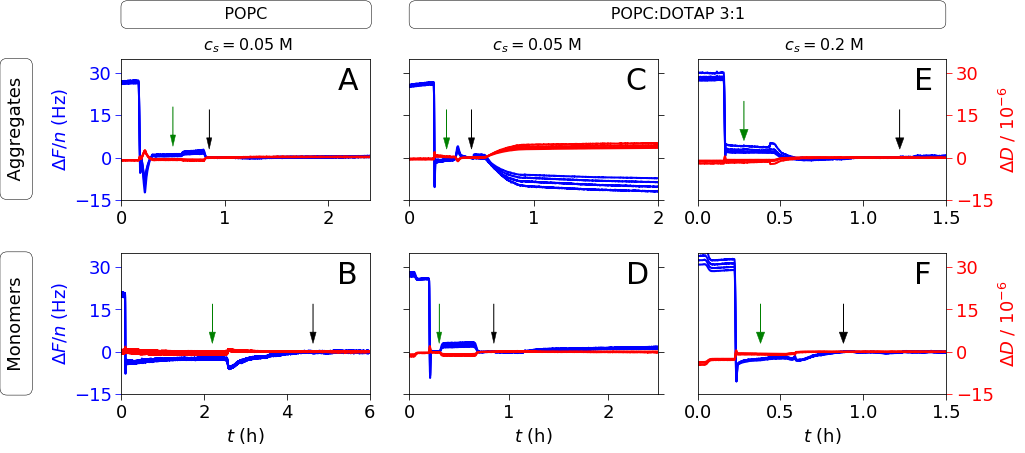

In [360]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [14, 6], 
                     'xtick.minor.size':3, 'xtick.major.size':6, 'ytick.minor.size':3, 'ytick.major.size':6})
f = plt.figure()

xticks = np.arange(0,5,1)
yticks = np.array([-15,0,15,30])

f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3)

# 50 mM fibrils POPC
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_ylim(-15,35)
ax1.set_xlim(0,2.4)
ax1.set_ylabel("$\Delta F/n$ (Hz)",color='blue')
ax1.tick_params(axis='y',colors='b')
ax1.arrow(.8-.3,18,0,-10, fc="g", ec="g",head_width=.05,head_length=4,lw=.5)
ax1.arrow(1.15-.3,17,0,-10, fc="k", ec="k",head_width=.05,head_length=4,lw=.5)
ax1.plot(F50fibPOPC[:,0]/3600-F50fibPOPC[0,0]/3600-.3,F50fibPOPC[:,1:],color='blue', lw=2)
ax1.plot(D50fibPOPC[:,0]/3600-F50fibPOPC[0,0]/3600-.3,D50fibPOPC[:,1:],color='red', lw=2)
ax1.text(-1.1,27.6,'  Aggregates  ',rotation=90,fontsize = 18,zorder = 6, color = 'k', 
        multialignment='center',
        bbox={'ec':'k','facecolor':'white', 'lw':.5, 'boxstyle':'round,pad=0.4'})
ax1.text(.06,49, '                   POPC                   ',fontsize = 16,zorder = 6, color = 'k', 
                multialignment='center',
                bbox={'ec':'k','facecolor':'white', 'lw':.5, 'boxstyle':'round,pad=0.4'})
ax1.text(.06,38, '               $c_s = 0.05$ M               ',fontsize = 16,zorder = 6, color = 'k', 
                multialignment='center',
                bbox={'ec':'white','facecolor':'white', 'alpha':0, 'lw':0, 'boxstyle':'round,pad=0.4'})

# 50 mM fibrils POPC:DOTAP
ax2.set_xticks(xticks)
ax2.set_yticks(yticks)
ax2.set_yticklabels(np.tile([''],yticks.size))
ax2.set_ylim(-15,35)
ax2.set_xlim(0,2)
ax2.yaxis.set_ticks_position('both')
ax2.arrow(1-.7,17,0,-10, fc="g", ec="g",head_width=.05,head_length=4,lw=.5)
ax2.arrow(1.2-.7,17,0,-10, fc="k", ec="k",head_width=.05,head_length=4,lw=.5)
ax2.plot(F50fibDOTAP[:,0]/3600-F50fibDOTAP[0,0]/3600-.7,F50fibDOTAP[:,1:],color='blue', lw=2)
ax2.plot(D50fibDOTAP[:,0]/3600-D50fibDOTAP[0,0]/3600-.7,D50fibDOTAP[:,1:],color='red', lw=2)
ax2.plot( [58], [-2], 's', ms=10, mew=3, mec='y', mfc='None')
ax2.text(.05,49, '                                      POPC:DOTAP 3:1                                      ',fontsize = 16,zorder = 6, color = 'k', multialignment='center',
                bbox={'ec':'k','facecolor':'white', 'lw':.5, 'boxstyle':'round,pad=0.4'})
ax2.text(.05,38, '               $c_s = 0.05$ M               ',fontsize = 16,zorder = 6, color = 'k', 
                multialignment='center',
                bbox={'ec':'white','facecolor':'white', 'alpha':0, 'lw':0, 'boxstyle':'round,pad=0.4'})

xticks = np.arange(0,5,.5)
# 200 mM fibrils POPC:DOTAP
ax3.set_xticks(xticks)
ax3.set_yticks(yticks)
ax3.set_ylim(-15,35)
ax3.set_xlim(0,1.5)
ax3.tick_params(axis='y',colors='r')
ax3.yaxis.tick_right()
ax3.set_ylabel("$\Delta D$ / 10$^{-6}$",color='red')
ax3.yaxis.set_label_position("right")
ax3.arrow(.48-.2,20,0,-10, fc="g", ec="g",head_width=.05,head_length=4,lw=.5)
ax3.arrow(1.42-.2,17,0,-10, fc="k", ec="k",head_width=.05,head_length=4,lw=.5)
ax3.plot(F200fibDOTAP[:,0]/3600-F200fibDOTAP[0,0]/3600-.2,F200fibDOTAP[:,1:],color='blue', lw=2)
ax3.plot(D200fibDOTAP[:,0]/3600-D200fibDOTAP[0,0]/3600-.2,D200fibDOTAP[:,1:],color='red', lw=2)
ax3.plot( [58], [-2], 's', ms=10, mew=3, mec='y', mfc='None')
ax3.text(.03,38, '                $c_s = 0.2$ M                ',fontsize = 16,zorder = 6, color = 'k', 
                multialignment='center',
                bbox={'ec':'white','facecolor':'white', 'alpha':0, 'lw':0, 'boxstyle':'round,pad=0.4'})

xticks = np.arange(0,5,1)
# 50 mM monomer POPC
ax4.set_xticks(np.arange(0,7,2))
ax4.set_yticks(yticks)
ax4.set_ylim(-15,35)
ax4.set_xlim(0,6)
ax4.set_ylabel("$\Delta F/n$ (Hz)",color='blue')
ax4.tick_params(axis='y',colors='b')
ax4.set_xlabel("$t$ (h)")
ax4.arrow(2.2,17,0,-10, fc="g", ec="g",head_width=.15,head_length=4,lw=.5)
ax4.arrow(4.63,17,0,-10, fc="k", ec="k",head_width=.15,head_length=4,lw=.5)
ax4.plot(F50monPOPC[:,0]/3600-F50monPOPC[0,0]/3600,F50monPOPC[:,1:],color='blue', lw=2)
ax4.plot(D50monPOPC[:,0]/3600-D50monPOPC[0,0]/3600,D50monPOPC[:,1:],color='red', lw=2)
ax4.text(-2.75,27.9,'   Monomers   ',rotation=90,fontsize = 18,zorder = 6, color = 'k', multialignment='center',
        bbox={'ec':'k','facecolor':'white', 'lw':.5, 'boxstyle':'round,pad=0.4'})

# 50 mM monomers POPC:DOTAP
ax5.set_xticks(xticks)
ax5.set_yticks(yticks)
ax5.set_yticklabels(np.tile([''],yticks.size))
ax5.set_ylim(-15,35)
ax5.set_xlim(0,2.5)
ax5.yaxis.set_ticks_position('both')
ax5.set_xlabel("$t$ (h)")
ax5.arrow(2-1.7,17,0,-10, fc="g", ec="g",head_width=.05,head_length=4,lw=.5)
ax5.arrow(2.55-1.7,17,0,-10, fc="k", ec="k",head_width=.05,head_length=4,lw=.5)
ax5.plot(F50monDOTAP[:,0]/3600-F50monDOTAP[0,0]/3600-1.7,F50monDOTAP[:,1:],color='blue', lw=2)
ax5.plot(D50monDOTAP[:,0]/3600-D50monDOTAP[0,0]/3600-1.7,D50monDOTAP[:,1:],color='red', lw=2)
ax5.plot( [15], [-2], 'o', ms=10, mew=3, mec='y', mfc='None')

xticks = np.arange(0,5,.5)
# 200 mM monomers POPC:DOTAP
ax6.set_xticks(xticks)
ax6.set_yticks(yticks)
ax6.set_ylim(-15,35)
ax6.set_xlim(0,1.5)
ax6.set_ylabel("$\Delta D$ / 10$^{-6}$",color='red')
ax6.tick_params(axis='y',colors='r')
ax6.yaxis.set_label_position("right")
ax6.yaxis.tick_right()
ax6.set_xlabel("$t$ (h)")
ax6.arrow(.5-.12,17,0,-10, fc="g", ec="g",head_width=.05,head_length=4,lw=.5)
ax6.arrow(1-.12,17,0,-10, fc="k", ec="k",head_width=.05,head_length=4,lw=.5)
ax6.plot(F200monDOTAP[:,0]/3600-F200monDOTAP[0,0]/3600-.12,F200monDOTAP[:,1:],color='blue', lw=2)
ax6.plot(D200monDOTAP[:,0]/3600-D200monDOTAP[0,0]/3600-.12,D200monDOTAP[:,1:],color='red', lw=2)
ax6.plot( [15], [-2], '^', ms=10, mew=3, mec='y', mfc='None')

ax1.annotate('A',xy=(0.87,.78), fontsize=30, xycoords='axes fraction')
ax2.annotate('C',xy=(0.87,.78), fontsize=30, xycoords='axes fraction')
ax3.annotate('E',xy=(0.87,.78), fontsize=30, xycoords='axes fraction')
ax4.annotate('B',xy=(0.87,.78), fontsize=30, xycoords='axes fraction')
ax5.annotate('D',xy=(0.87,.78), fontsize=30, xycoords='axes fraction')
ax6.annotate('F',xy=(0.87,.78), fontsize=30, xycoords='axes fraction')

f.tight_layout()
f.savefig('fig1_SI.eps', bbox_inches='tight', pad_inches=0.3)
plt.show()

Analysis of QCM-D data for different batches of sonicated fibrils

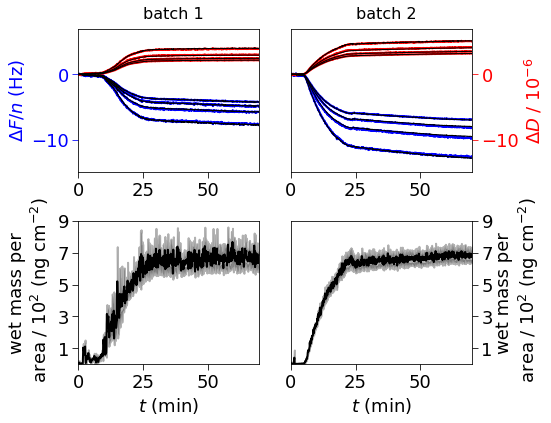

In [24]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8.0, 6.0]})
f = plt.figure()

xticks = np.arange(0,19,3)

# 50 mM fibrils, batch 1
ax = f.add_subplot(221)
plt.ylim(-15,7)
ax.text(25,8.5,'batch 1',fontsize=16)
plt.xlim(0,70)
plt.ylabel("$\Delta F/n$ (Hz)",color='blue')
ax.tick_params(axis='y',colors='b')
plt.plot(F50fib[1:,0]/60,F50fib[1:,1:],color='blue', lw=2)
plt.plot(D50fib[1:,0]/60,D50fib[1:,1:],color='red', lw=2)
plt.plot(Fit50fib[1:,0]/60,Fit50fib[1:,1:],color='black', lw=1)

# 50 mM fibrils, batch 2
ax = f.add_subplot(222)
ax.text(25,8.5,'batch 2',fontsize=16)
ax.yaxis.tick_right()
ax.tick_params(axis='y',colors='r')
plt.ylim(-15,7)
plt.xlim(0,70)
plt.ylabel("$\Delta D$ / 10$^{-6}$",color='red')
ax.yaxis.set_label_position("right")
plt.plot(F50fib2[1:,0]/60,F50fib2[1:,1:],color='blue', lw=2)
plt.plot(D50fib2[1:,0]/60,D50fib2[1:,1:],color='red', lw=2)
plt.plot(Fit50fib2[1:,0]/60,Fit50fib2[1:,1:],color='black', lw=1)

# mass per area, batch 1
ax = f.add_subplot(223)
plt.yticks(np.arange(1,10,2))
plt.ylim(0,9)
plt.xlim(0,70)
plt.ylabel("wet mass per\n area / 10$^2$ (ng cm$^{-2}$)",color='k')
plt.xlabel("$t$ (min)")
plt.plot(mass50fib[:,0]/60,
          mass50fib[:,1:].mean(axis=1),color='k',lw=2)
plt.fill_between(mass50fib[:,0]/60,
          mass50fib[:,1:].mean(axis=1)
        + mass50fib[:,1:].std(axis=1),
          mass50fib[:,1:].mean(axis=1)
        - mass50fib[:,1:].std(axis=1),color='k',lw=2,alpha=.3)

# mass per area, batch 2
ax = f.add_subplot(224)
plt.yticks(np.arange(1,10,2))
ax.yaxis.tick_right()
plt.ylim(0,9)
plt.xlim(0,70)
plt.ylabel("wet mass per\n area / 10$^2$ (ng cm$^{-2}$)",color='k')
plt.xlabel("$t$ (min)")
ax.yaxis.set_label_position("right")
plt.plot(mass50fib2[:,0]/60,
          mass50fib2[:,1:].mean(axis=1),color='k',lw=2)
plt.fill_between(mass50fib2[:,0]/60,
          mass50fib2[:,1:].mean(axis=1)
        + mass50fib2[:,1:].std(axis=1),
          mass50fib2[:,1:].mean(axis=1)
        - mass50fib2[:,1:].std(axis=1),color='k',lw=2,alpha=.3)

f.tight_layout(h_pad=0)
f.savefig('fig3_SI.pdf', bbox_inches='tight', pad_inches=0.3)
plt.show()

Deposition of the POPC:DOTAP 3:1 lipid bilayer

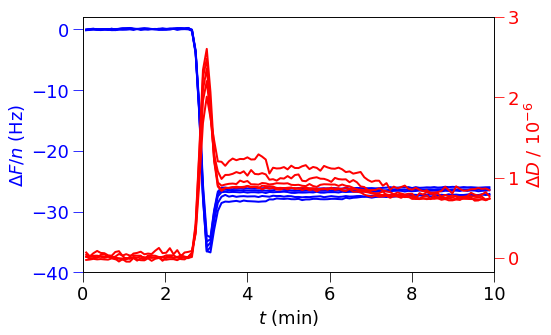

In [25]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8,5], 
                     'xtick.minor.size':5, 'xtick.major.size':10, 'ytick.minor.size':5, 'ytick.major.size':10})

xticks = np.arange(0,19,3)

fig, ax1 = plt.subplots()
t = np.arange(0.01, 10.0, 0.01)
plt.plot(Fslb[1:,0]/60,Fslb[1:,1:],color='blue', lw=2)
ax1.set_xlabel('$t$ (min)')
ax1.tick_params(axis='y',colors='b')

ax1.set_ylabel("$\Delta F/n$ (Hz)",color='blue')
ax1.set_yticks(np.arange(-40,10,10))

ax2 = ax1.twinx()
plt.plot(Dslb[1:,0]/60,Dslb[1:,1:],color='red', lw=2)
ax2.tick_params(axis='y',colors='r')
plt.ylabel("$\Delta D$ / 10$^{-6}$",color='red')
ax2.set_yticks(range(4))

plt.xlim(0,10)

fig.tight_layout()
fig.savefig('fig2_SI.pdf', bbox_inches='tight', pad_inches=0.3)
plt.show()

# Preferential Aggregate Orientation

In [26]:
%%writefile mc/submit.sh
#!/bin/bash
#SBATCH -p snic
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -A snic2017-1-48
#
# job time, change for what your job requires 
#SBATCH -t 20:00:00
# 
# job name
#SBATCH -J fibril
#
# filenames stdout and stderr - customise, include %j
#SBATCH -o fibrils.out
#SBATCH -e fibrils.err

module purge
module add GCC/6.2.0-2.27
module add CMake

../../theta > out

Overwriting mc/submit.sh


In [27]:
%cd $workdir

def mkinput():
    js = {
      "atomlist" : {
        "NTR"  :  { "q":charge_ntr,  "r":3.6, "mw":110 },
        "ASP"  :  { "q":-1, "r":3.6, "mw":110 },
        "CTR"  :  { "q":-1, "r":3.1, "mw":66 },
        "ALA"  :  { "q":0,  "r":3.1, "mw":66 },
        "GLU"  :  { "q":-1, "r":3.8, "mw":122 },
        "HIS"  :  { "q":0,  "r":3.9, "mw":130 },
        "TYR"  :  { "q":0,  "r":4.1, "mw":154 },
        "LYS"  :  { "q":1,  "r":3.7, "mw":116 },
        "CYS"  :  { "q":0,  "r":3.6, "mw":103 },
        "ARG"  :  { "q":1,  "r":4.0, "mw":144 },
        "ILE"  :  { "q":0,  "r":3.6, "mw":102 },
        "LEU"  :  { "q":0,  "r":3.6, "mw":102 },
        "MET"  :  { "q":0,  "r":3.8, "mw":122 },
        "PHE"  :  { "q":0,  "r":3.9, "mw":138 },
        "PRO"  :  { "q":0,  "r":3.4, "mw":90 },
        "TRP"  :  { "q":0,  "r":4.3, "mw":176 },
        "VAL"  :  { "q":0,  "r":3.4, "mw":90 },
        "SER"  :  { "q":0,  "r":3.3, "mw":82 },
        "THR"  :  { "q":0,  "r":3.5, "mw":94 },
        "ASN"  :  { "q":0,  "r":3.6, "mw":108 },
        "GLN"  :  { "q":0,  "r":3.8, "mw":120 },
        "GLY"  :  { "q":0,  "r":2.9, "mw":54 }
          },  
      "energy" : {
          "gouychapman" : { "qarea": qarea, "offset":3 },
          "nonbonded" : {
            "coulomb"  : { "epsr" : 78.54 },
            "ionicstrength": salt 
            },
          "penalty" : { 
                "xyz" : { "dir":"0 0 1", "first":"fibril", "bw1":1,  
                         "lo1":-len_z/4+min_dist, "hi1":len_z/2-min_dist,
                         "f0":0, "scale":0.5, "update":1e20} 
            }  
          },
      "moves" : {
          "moltransrot"      : { "fibril" : { "dp":20, "dprot":6, "permol":True }  }
          },
      "moleculelist" : {
          "fibril" : { "Ninit":1, "structure":str(numpep)+".xyz" } 
          },
      "system" : {
          "temperature"  : 298,
          "geometry"   : { "length" : [2000, 2000, len_z] },
          "mcloop"       : { "macro":10, "micro": micro }
          },
      "analysis" : {
          "statefile" : { "file": "state" }
          }
    }
    with open('input.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))
        f.close()

%cd -q $workdir'/mc'

# parameter space
qarea        = 266 # 1 / surface charge density (angstrom^2/charge)
micro        = 8000000
len_z        = 600

fibrils = { '5KK3': {'peplen':42, 'startres': 1, 'file': '5KK3.pdb', 'min_dist':[27,29,32],
                     'numpep_range':[32,64,128], 'charge_ntr': 0, 'salt': 0.4 },
            '2BEG_17-42': {'peplen':26, 'startres': 1, 'file': '2BEG_17-42.pdb', 
                     'min_dist':[20,21,23], 'numpep_range':[32,64,128], 'charge_ntr': 1, 'salt': 0.2 },
            '2M4J': {'peplen':40, 'startres': 1, 'file': '2M4J.pdb', 'min_dist':[28,31,36],
                     'numpep_range':[48,96,192], 'charge_ntr': 0, 'salt': 0.4 }
          }

for name in ['5KK3','2M4J','2BEG_17-42']:
    if not Path('theta-data.p').is_file(): # run only if this file is missing (see next section)
        fibril = fibrils[name]
        charge_ntr = fibril['charge_ntr']
        pdb = md.load_pdb(fibril['file'])
        if not os.path.isdir(name):
            %mkdir -p $name
        %cd $name
        salt = fibril['salt']
        for numpep, min_dist in zip(fibril['numpep_range'],fibril['min_dist']):
            pfx='__rho'+str(qarea)+'-N'+str(numpep)+'-I'+str(salt)
            if not os.path.isdir(pfx):
                print(min_dist)
                %mkdir -p $pfx     
                %cd $pfx
                mkinput()
                for N, d in data[0.2].items():
                    if N==numpep:
                        r = np.arange(-len_z/4+min_dist, len_z/2-min_dist+1,1)
                        w = -d['pmf'] # [:r.size]
                        w = np.append(w,np.tile(w[-1],r.size-w.size))
                        w = np.flip(w,axis=0)
                        np.savetxt('pf_penalty',np.column_stack((r,w)))
                # generate CG aggregate
                cg_agg = extract_agg( pdb, numpep, fibril['peplen'], fibril['startres'] )
                cg_agg[0].save_xyz(str(numpep)+'.xyz')
                if shutil.which('sbatch') is not None:
                    !sbatch ../../submit.sh  # run on slurm cluster
                else:
                    !../../theta > out         # run locally
                %cd -q ..
        %cd -q ..

/Users/giulio/JPCL-submit/SI


In [36]:
if Path('theta-data.p').is_file():
    data = pd.read_pickle('theta-data.p')
else:
    d = {}
    for name in ['2BEG_17-42','5KK3','2M4J']:
        fibril = fibrils[name]
        d[name] = {}
        salt = fibril['salt']
        for numpep in fibril['numpep_range']:
            pfx=name+'/__rho'+str(qarea)+'-N'+str(numpep)+'-I'+str(salt)
            distfile=pfx+'/hist2d.dat'
            if os.path.isfile(distfile):
                p = np.loadtxt(distfile)
                d[name][numpep] = { 'c_s': salt, 'hist': p }
        if len( d[name] ) > 0:
            d[name] = pd.Series(d[name])
    data = pd.DataFrame(d)
    data.to_pickle('theta-data.p')
data

,2BEG_17-42,2M4J,5KK3
32,"{'c_s': 0.2, 'hist': [[37401.0, 0.0, 1.0, 2.0,...",NaN,"{'c_s': 0.4, 'hist': [[36127.0, 0.0, 1.0, 2.0,..."
48,NaN,"{'c_s': 0.4, 'hist': [[35945.0, 0.0, 1.0, 2.0,...",NaN
64,"{'c_s': 0.2, 'hist': [[37219.0, 0.0, 1.0, 2.0,...",NaN,"{'c_s': 0.4, 'hist': [[35763.0, 0.0, 1.0, 2.0,..."
96,NaN,"{'c_s': 0.4, 'hist': [[35399.0, 0.0, 1.0, 2.0,...",NaN
128,"{'c_s': 0.2, 'hist': [[36855.0, 0.0, 1.0, 2.0,...",NaN,"{'c_s': 0.4, 'hist': [[35217.0, 0.0, 1.0, 2.0,..."
192,NaN,"{'c_s': 0.4, 'hist': [[61789.0, 0.0, 1.0, 2.0,...",NaN


In [43]:
def plotP(subplot,N,pep,fib='5KK3'):
    data = pd.read_pickle('theta-data.p')
    p = data.loc[N][fib]['hist']
    cs = '$c_s=$'+str(data.loc[N][fib]['c_s'])+' M'
    y = p[0,1:]
    x = p[1:,0]
    Z = p[1:,1:][::-1].T
    Z[-1,:] = Z[-1,:]*2
    Z[:,-1] = Z[:,-1]*2

    corr = np.sin(np.tile(y/180*np.pi,(x.size,1)).T)
    Z = Z/corr
    Z = Z/Z[1:,-10:].mean()

    #L/4 = x[0]+x[-1]
    #min_dist = x[0] + L/4
    x = x + x[0] + x[-1]
    min_z = Z[-1,10:].min()
    zx = Z[-1,:]
    len_agg = x[zx==min_z]*2
    
    x = x / len_agg
    
    Z = -np.log(Z)
    
    vmin=-1.5
    vmax=1.5
    
    im = subplot.imshow(Z,cmap=cm.viridis,extent=[x.min(),x.max(),90,0],
                    origin='lower',aspect='auto',vmin=vmin, vmax=vmax)
    subplot.set_ylim(0,89)
    subplot.set_yticks(np.arange(0,81,20))
    
    subplot.set_xlim(x.min(),.9)
    cb = colorbar(im,ax=subplot,ticks=np.arange(vmin,vmax+1,1),label=r'Free Energy ($k_BT$)')
    subplot.set_xticks(np.arange(.3,.91,.2))
    subplot.annotate(pep+'\n$N=$'+str(N)+'\n'+cs,xy=(0.6,.6), fontsize=20, xycoords='axes fraction',color='k')
    return cb

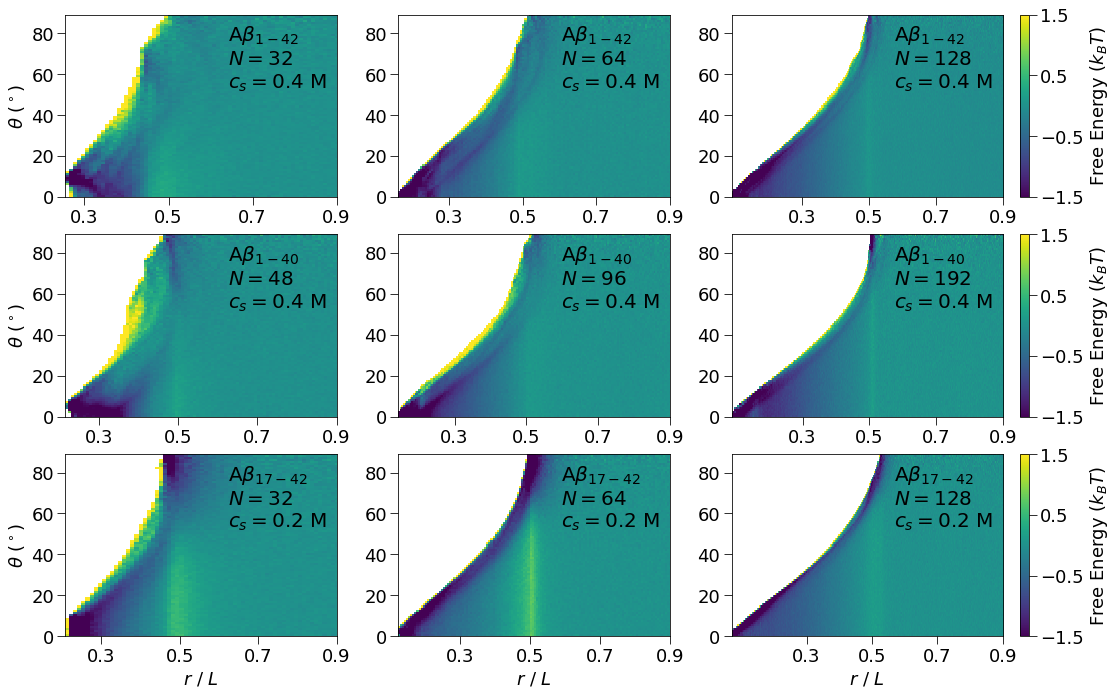

In [443]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [16, 10], 
                     'xtick.minor.size':5, 'xtick.major.size':8, 'ytick.minor.size':5, 'ytick.major.size':8})

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex=False, sharey=False)
cb1 = plotP(ax1,fib='5KK3',N=32,pep=r'A$\beta_{1-42}$')
ax1.set_ylabel(r'$\theta$ ($^\circ$)')
cb2 = plotP(ax2,fib='5KK3',N=64,pep=r'A$\beta_{1-42}$')
plotP(ax3,fib='5KK3',N=128,pep=r'A$\beta_{1-42}$')

cb4 = plotP(ax4,fib='2M4J',N=48,pep=r'A$\beta_{1-40}$')
ax4.set_ylabel(r'$\theta$ ($^\circ$)')
cb5 = plotP(ax5,fib='2M4J',N=96,pep=r'A$\beta_{1-40}$')
plotP(ax6,fib='2M4J',N=192,pep=r'A$\beta_{1-40}$')

cb7 = plotP(ax7,fib='2BEG_17-42',N=32,pep=r'A$\beta_{17-42}$')
ax7.set_ylabel(r'$\theta$ ($^\circ$)')
cb8 = plotP(ax8,fib='2BEG_17-42',N=64,pep=r'A$\beta_{17-42}$')
plotP(ax9,fib='2BEG_17-42',N=128,pep=r'A$\beta_{17-42}$')
ax7.set_xlabel('$r$ / $L$')
ax8.set_xlabel('$r$ / $L$')
ax9.set_xlabel('$r$ / $L$')
plt.tight_layout(w_pad=-5,h_pad=0)
cb1.remove()
cb2.remove()
cb4.remove()
cb5.remove()
cb7.remove()
cb8.remove()
plt.savefig('fig7_SI.pdf')
plt.show()

# Counterion Condensation and Compesation of Linear Charge Density

In [47]:
%cd $workdir

/Users/giulio/JPCL-submit/SI


In [48]:
%%writefile mc/submit.sh
#!/bin/bash
#SBATCH -p snic
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -A snic2017-1-48
#
# job time, change for what your job requires 
#SBATCH -t 20:00:00
# 
# job name
#SBATCH -J fibril
#
# filenames stdout and stderr - customise, include %j
#SBATCH -o fibrils.out
#SBATCH -e fibrils.err

module purge
module add GCC/6.2.0-2.27
module add CMake

../../cc > out

Overwriting mc/submit.sh


In [450]:
%cd $workdir

def mkinput():
    js = {
      "atomlist" : {
        "NTR"  :  { "q":charge_ntr,  "r":3.6, "mw":110, "eps":1 },
        "ASP"  :  { "q":-1, "r":3.6, "mw":110, "eps":1 },
        "CTR"  :  { "q":-1, "r":3.1, "mw":66, "eps":1 },
        "ALA"  :  { "q":0,  "r":3.1, "mw":66, "eps":1 },
        "GLU"  :  { "q":-1, "r":3.8, "mw":122, "eps":1 },
        "HIS"  :  { "q":0,  "r":3.9, "mw":130, "eps":1 },
        "TYR"  :  { "q":0,  "r":4.1, "mw":154, "eps":1 },
        "LYS"  :  { "q":1,  "r":3.7, "mw":116, "eps":1 },
        "CYS"  :  { "q":0,  "r":3.6, "mw":103, "eps":1 },
        "ARG"  :  { "q":1,  "r":4.0, "mw":144, "eps":1 },
        "ILE"  :  { "q":0,  "r":3.6, "mw":102, "eps":1 },
        "LEU"  :  { "q":0,  "r":3.6, "mw":102, "eps":1 },
        "MET"  :  { "q":0,  "r":3.8, "mw":122, "eps":1 },
        "PHE"  :  { "q":0,  "r":3.9, "mw":138, "eps":1 },
        "PRO"  :  { "q":0,  "r":3.4, "mw":90, "eps":1 },
        "TRP"  :  { "q":0,  "r":4.3, "mw":176, "eps":1 },
        "VAL"  :  { "q":0,  "r":3.4, "mw":90, "eps":1 },
        "SER"  :  { "q":0,  "r":3.3, "mw":82, "eps":1 },
        "THR"  :  { "q":0,  "r":3.5, "mw":94, "eps":1 },
        "ASN"  :  { "q":0,  "r":3.6, "mw":108, "eps":1 },
        "GLN"  :  { "q":0,  "r":3.8, "mw":120, "eps":1 },
        "GLY"  :  { "q":0,  "r":2.9, "mw":54, "eps":1 },
        "NA"   :  { "q":na_q,  "r":na_r, "mw":23, "eps":1, "dp": 150}
          },  
      "energy" : {
          "nonbonded" : {
            "coulomb"  : { "epsr" : 78.54 }
            }  
          },
      "moves" : {
          "atomtranslate": { "sodium": { "permol": True, "prob": 1 } }
          },
      "moleculelist" : {
          "fibril" : { "Ninit":1, "structure":str(numpep)+".xyz" },
          "sodium": { "Ninit": numcat, "atomic": True, "atoms": "NA" }
          },
      "system" : {
          "temperature"  : 298,
          "geometry" : { "length" : length, "radius" : radius },
          "mcloop"       : { "macro":10, "micro": micro }
          },
      "analysis" : {
          "statefile" : { "file": "state" },
          "xtcfile" :   { "file": "traj.xtc", "nstep":500 }
          }
    }
        
    with open('input.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))
        f.close()

%cd -q $workdir'/mc'

# parameter space
NA           = 6.022e23   # Avogadros number (1/mol)
qarea        = 266 # 1 / surface charge density (angstrom^2/charge)
micro        = 200000

fibrils = { '5KK3': {'peplen':42, 'startres': 1, 'file': '5KK3.pdb', 'lm':3.05, 'pepchar':-3,
                     'numpep_range':[120], 'charge_ntr': 0 },
            '2BEG_17-42': {'peplen':26, 'startres': 1, 'file': '2BEG_17-42.pdb', 'pepchar':-1, 
                     'lm':2.7, 'numpep_range':[130], 'charge_ntr': 1 },
            '2M4J': {'peplen':40, 'startres': 1, 'file': '2M4J.pdb', 'lm':2.35, 'pepchar':-3,
                     'numpep_range':[150], 'charge_ntr': 0 }
          }

for name in ['2BEG_17-42','2M4J','5KK3']:
    if not Path('cc-data.p').is_file(): # run only if this file is missing (see next section)
        fibril = fibrils[name]
        charge_ntr = fibril['charge_ntr']
        pdb = md.load_pdb(fibril['file'])
        if not os.path.isdir(name):
            %mkdir -p $name
        %cd $name
        for numpep in fibril['numpep_range']:
            for na_q, conc in zip([1,2],[[0.0005,0.001,0.01],[0.001]]):
                na_r = 1.9
                lm = fibril['lm']
                length = numpep * lm
                print('Fibril length:',length)
                numcat = abs(fibril['pepchar']) * numpep
                pfx='__conc'+str(conc)+'-N'+str(numpep)+'-q'+str(na_q)+'-r'+str(na_r)
                radius  = np.sqrt( numpep*3e4 / (6.022*np.pi*length*conc) ) # radius for conc. 
                if not os.path.isdir(pfx):
                    %mkdir -p $pfx     
                    %cd $pfx
                    mkinput()
                    # generate CG aggregate
                    cg_agg = extract_agg( pdb, numpep, fibril['peplen'], fibril['startres'] )
                    cg_agg[0].save_xyz(str(numpep)+'.xyz')
                    if shutil.which('sbatch') is not None:
                        !sbatch ../../submit.sh  # run on slurm cluster
                    else:
                        !../../man > out         # run locally
                %cd -q ..
            %cd -q ..

/Users/giulio/JPCL-submit/SI


In [733]:
def plotCumSum(subplot,fib):
    data = pd.read_pickle('cc-data.p')
    for q, d in data[fib].items(): # at 0.4 mol/l salt
        if (q==1):
            g = np.gradient(d[0.001]['cat'])
            h = d[0.0005]['cat_agg']
            i = d[0.001]['cat_agg']
            l = d[0.01]['cat_agg']
            r = d[0.001]['r']
            print(fib,'ionic strength:',0.25,'mM,',0.5,'mM,',5,'mM,')
            print(h[g==g.max()],i[g==g.max()],l[g==g.max()])
            subplot.vlines(x=r[g==g.max()],ymin=-3.2,ymax=3,color='k',linestyle='--',lw=1)
            subplot.plot( d[0.01]['r'], d[0.01]['agg'], color='#7f7f7f', lw=3)
            subplot.plot( d[0.0005]['r'], d[0.0005]['cat'], color='#1f77b4', lw=3)
            subplot.plot( d[0.0005]['r'], d[0.0005]['cat_agg'], color='#d62728', lw=3)
        if (q==2):
            subplot.plot( d[0.001]['r'], d[0.001]['cat'], color='#1f77b4', ls='--', lw=3)
            subplot.plot( d[0.001]['r'], d[0.001]['cat_agg'], color='#d62728', ls='--', lw=3)
    subplot.set_xlim(0,6.5)
    subplot.set_ylim(-3.2,2.5)
    subplot.set_xticks(np.arange(0,7,2))
    subplot.set_yticks([-3,-2,-1,0,1,2])
    subplot.set_xlabel('$R_c$ (nm)')

5KK3 ionic strength: 0.25 mM, 0.5 mM, 5 mM,
[-1.54586072] [-1.52768574] [-1.51382209]
2M4J ionic strength: 0.25 mM, 0.5 mM, 5 mM,
[-1.35001042] [-1.34493904] [-1.31302898]
2BEG_17-42 ionic strength: 0.25 mM, 0.5 mM, 5 mM,
[-1.01635653] [-1.01740455] [-0.99784674]


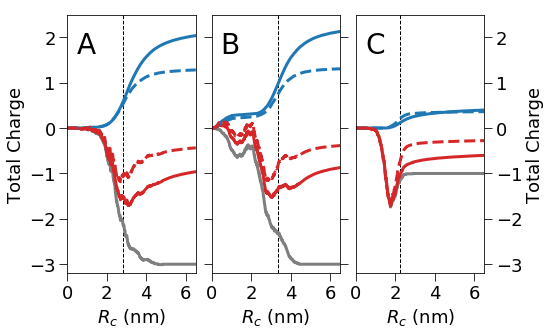

In [734]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [8, 5], 
                     'xtick.minor.size':5, 'xtick.major.size':8, 'ytick.minor.size':5, 'ytick.major.size':8})
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=False)
plotCumSum(ax1,'5KK3')
plotCumSum(ax2,'2M4J')
plotCumSum(ax3,'2BEG_17-42')

ax1.set_ylabel('Total Charge')
ax3.set_ylabel('Total Charge')
ax3.yaxis.set_label_position("right")
ax2.set_yticklabels(np.tile([''],7))
ax2.yaxis.set_ticks_position('both')
ax3.yaxis.set_ticks_position('right')
#ax1.annotate(r'A$\beta_{1-42}$',xy=(0.07,.85), fontsize=20, xycoords='axes fraction',color='k')
#ax2.annotate(r'A$\beta_{1-40}$',xy=(0.07,.85), fontsize=20, xycoords='axes fraction',color='k')
#ax3.annotate(r'A$\beta_{17-42}$',xy=(0.07,.85), fontsize=20, xycoords='axes fraction',color='k')
ax1.annotate(r'A',xy=(0.07,.85), fontsize=28, xycoords='axes fraction',color='k')
ax2.annotate(r'B',xy=(0.07,.85), fontsize=28, xycoords='axes fraction',color='k')
ax3.annotate(r'C',xy=(0.07,.85), fontsize=28, xycoords='axes fraction',color='k')
plt.tight_layout(w_pad=0)
plt.savefig('fig5.eps')
plt.show()

# Atomic Force Microscopy Measurements

In [728]:
def plotAFM(path,subplot,cm,l='',r=(-10,30)):
    um = int(path.split('um')[0][-1])
    x,y,z = np.loadtxt(path,unpack=True,skiprows=7,usecols=(0,2,4))
    img = z.reshape((256,256))[::-1]
    vmin, vmax = r
    pixels = img.shape[0]+1
    subplot.set_xticks(np.linspace(0,pixels,um+1))
    subplot.set_xticklabels(list(map(str, range(um+1))))
    subplot.set_yticks(np.linspace(0,pixels,um+1))
    subplot.set_yticklabels(list(map(str, range(um+1))))
    imgplot = subplot.imshow(img,aspect=1,cmap=cm,vmax=vmax,vmin=vmin,extent=[0,pixels,0,pixels])
    cb = colorbar(imgplot,ax=subplot,ticks=np.linspace(vmin,vmax,6),fraction=.0455,label=l)
    cb.ax.set_yticklabels(['{:1.0f}'.format(i) for i in np.linspace(vmin,vmax,6)]) 
    return cb

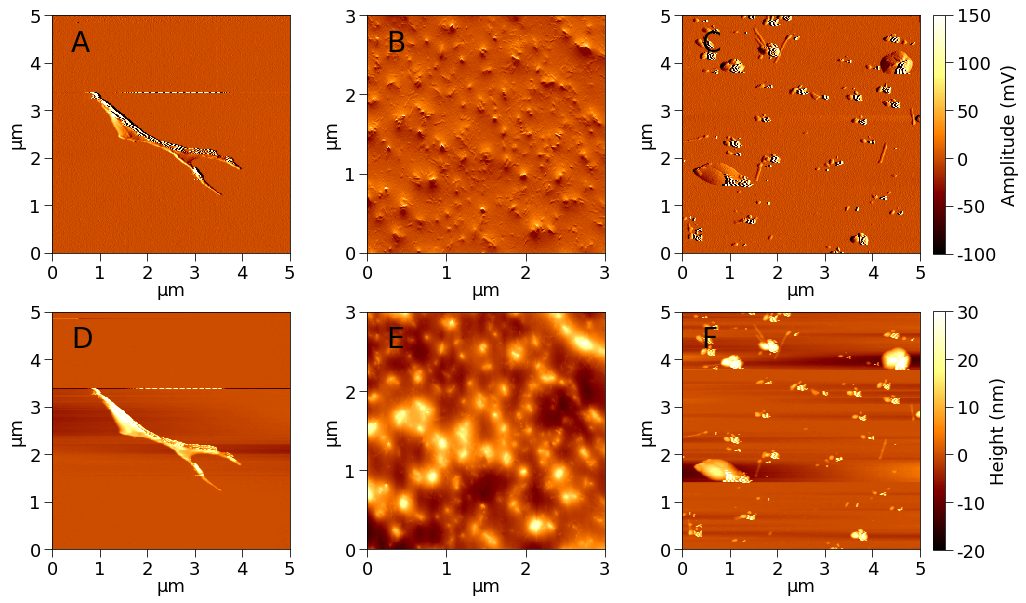

In [729]:
plt.rcParams.update({'font.size': 18, 'figure.figsize': [16, 10], 
                     'xtick.minor.size':5, 'xtick.major.size':8, 'ytick.minor.size':5, 'ytick.major.size':8})

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

r1=(-100,150)
r2=(-20,30)
cb1 = plotAFM('../exp/AFM/nonsonicated_10uMab40_50mM_5x5um_amplitude.txt',ax1,cm=cm.afmhot,r=r1)
cb2 = plotAFM('../exp/AFM/sonicated_10uMab40_50mM_3x3um_amplitude.txt',ax2,cm=cm.afmhot,r=r1)
cb3 = plotAFM('../exp/AFM/sonicated_10uMab40_200mM_5x5um_amplitude.txt',ax3,cm=cm.afmhot,l='Amplitude (mV)',r=r1)
cb4 = plotAFM('../exp/AFM/nonsonicated_10uMab40_50mM_5x5um_topography.txt',ax4,cm=cm.afmhot,r=r2)
cb5 = plotAFM('../exp/AFM/sonicated_10uMab40_50mM_3x3um_topography.txt',ax5,cm=cm.afmhot,r=r2)
cb6 = plotAFM('../exp/AFM/sonicated_10uMab40_200mM_5x5um_topography.txt',ax6,cm=cm.afmhot,l='Height (nm)',r=r2)

cb1.remove()
cb2.remove()
cb4.remove()
cb5.remove()

for ax,letter in zip(f.axes[:-2],['A','B','C','D','E','F']):
    ax.set_ylabel(u'µm')
    ax.set_xlabel(u'µm',labelpad=-1)
    ax.annotate(letter,xy=(0.08,.85), fontsize=28, xycoords='axes fraction', color='k')

plt.savefig('fig4_SI.pdf')
plt.show()